In [1]:
# Packages laden
import numpy as np
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Input, Dense
from matplotlib import pyplot as plt
from pandas import DataFrame
from keras.datasets import mnist
from keras.utils import np_utils
from keras.layers import Dropout, Activation, Flatten,TimeDistributed, BatchNormalization, LeakyReLU, Activation 
from keras.models import Model
from pandas import concat
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Laden der Daten
DATA_FILE="Dropbox/Masterarbeit/Masterarbeit/Datensätze/Geburtenrate/Datensatz.xlsx"
df = pd.read_excel(DATA_FILE)
df=pd.read_excel(DATA_FILE, header=0, parse_dates=[0], index_col='Jahr-Monat',squeeze=True)

In [3]:
# Ein array mit allen Einträgen --> zur besseren Weiterverarbeitung
ZR=df.values

In [4]:
ZR = ZR.reshape((len(ZR), 1))
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(ZR)
ZR_N = scaler.transform(ZR)

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [5]:
# Anteil der Datensätze am Gesamtdatensatz
ZR_100=ZR
ZR_46=ZR[-400:]

# Unterteilung der Teildatensätze in Trainings-und Testdaten
ZR_100_TR, ZR_100_TE= ZR_100[0:605], ZR_100[605:len(ZR_100)]
ZR_46_TR, ZR_46_TE= ZR_46[0:250], ZR_46[250:len(ZR_46)]

# Anteil der Datensätze am Gesamtdatensatz: normalisierte Daten
ZR_N100=ZR_N
ZR_N46=ZR_N[-400:]

# Unterteilung der Teildatensätze in Trainings-und Testdaten
ZR_N100_TR, ZR_N100_TE= ZR_N100[0:605], ZR_N100[605:len(ZR_N100)]
ZR_N46_TR, ZR_N46_TE= ZR_N46[0:250], ZR_N46[250:len(ZR_N46)]

In [6]:
# Funktion: Datensatz erstellen mit Inputs (look_back: Anzahl der verwendten Vergangenheitswerte) + Output (look_forward: 
# Vorhersagehorizont)
def timeseries_to_supervised_R(data, look_back, look_forward):
    df = DataFrame(data)
    columns = [df.shift(look_forward-1+i) for i in range(1, look_back+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    #df = df.drop(0)
    DF=df[::-1]
    df=DF[:len(df)-(look_back+look_forward-1)]
    DF=df[::-1]
    return DF

In [8]:
# Festlegung: look_back, look_forward + Anwendung der Funktion
# Inputneuronen: 12
# Vorhersagehorizont: t+60
look_back=12
look_forward=60

# Inputgröße 100%
# Trainingsdaten
ZR_100_TR_I=timeseries_to_supervised_R(ZR_100_TR, look_back, look_forward)
trainX_100, train_y_100 = ZR_100_TR_I.iloc[:, 0:-1], ZR_100_TR_I.iloc[:, -1]

# Testdaten 
ZR_100_TE_I=timeseries_to_supervised_R(ZR_100_TE, look_back, look_forward)
testX_100, test_y_100 = ZR_100_TE_I.iloc[:, 0:-1], ZR_100_TE_I.iloc[:, -1]


# Inputgröße 46%
# Trainingsdaten
ZR_46_TR_I=timeseries_to_supervised_R(ZR_46_TR, look_back, look_forward)
trainX_46, train_y_46 = ZR_46_TR_I.iloc[:, 0:-1], ZR_46_TR_I.iloc[:, -1]

# Testdaten 
ZR_46_TE_I=timeseries_to_supervised_R(ZR_46_TE, look_back, look_forward)
testX_46, test_y_46 = ZR_46_TE_I.iloc[:, 0:-1], ZR_46_TE_I.iloc[:, -1]

In [9]:
# Normalisierten Daten
# Inputgröße 100%
# Trainingsdaten
ZR_N100_TR_I=timeseries_to_supervised_R(ZR_N100_TR, look_back, look_forward)
trainX_100N, train_y_100N = ZR_N100_TR_I.iloc[:, 0:-1], ZR_N100_TR_I.iloc[:, -1]

# Testdaten 
ZR_N100_TE_I=timeseries_to_supervised_R(ZR_N100_TE, look_back, look_forward)
testX_100N, test_y_100N = ZR_N100_TE_I.iloc[:, 0:-1], ZR_N100_TE_I.iloc[:, -1]


# Inputgröße 46%
# Trainingsdaten
ZR_N46_TR_I=timeseries_to_supervised_R(ZR_N46_TR, look_back, look_forward)
trainX_46N, train_y_46N = ZR_N46_TR_I.iloc[:, 0:-1], ZR_N46_TR_I.iloc[:, -1]

# Testdaten 
ZR_N46_TE_I=timeseries_to_supervised_R(ZR_N46_TE, look_back, look_forward)
testX_46N, test_y_46N = ZR_N46_TE_I.iloc[:, 0:-1], ZR_N46_TE_I.iloc[:, -1]

In [12]:
# neuer Code: Optimierung der Gewichte
model = Sequential()
model.add(Dense(10, input_dim=look_back, activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
k = 50
test_MSE=[0]*k
for i in range(20+k):
    np.random.seed(i)
    model.fit(trainX_100N, train_y_100N, epochs=200, batch_size=25, verbose=2,validation_data=(testX_100N, test_y_100N))
    testPredict_100N = model.predict(testX_100N)
    testPredict_100=scaler.inverse_transform(testPredict_100N)
    test_MSE[i]=mean_squared_error(test_y_100,testPredict_100)

Train on 534 samples, validate on 187 samples
Epoch 1/200
 - 0s - loss: 0.0339 - val_loss: 0.0329
Epoch 2/200
 - 0s - loss: 0.0306 - val_loss: 0.0227
Epoch 3/200
 - 0s - loss: 0.0302 - val_loss: 0.0226
Epoch 4/200
 - 0s - loss: 0.0297 - val_loss: 0.0189
Epoch 5/200
 - 0s - loss: 0.0289 - val_loss: 0.0159
Epoch 6/200
 - 0s - loss: 0.0291 - val_loss: 0.0125
Epoch 7/200
 - 0s - loss: 0.0287 - val_loss: 0.0152
Epoch 8/200
 - 0s - loss: 0.0282 - val_loss: 0.0108
Epoch 9/200
 - 0s - loss: 0.0282 - val_loss: 0.0124
Epoch 10/200
 - 0s - loss: 0.0279 - val_loss: 0.0104
Epoch 11/200
 - 0s - loss: 0.0278 - val_loss: 0.0108
Epoch 12/200
 - 0s - loss: 0.0277 - val_loss: 0.0100
Epoch 13/200
 - 0s - loss: 0.0276 - val_loss: 0.0090
Epoch 14/200
 - 0s - loss: 0.0276 - val_loss: 0.0086
Epoch 15/200
 - 0s - loss: 0.0275 - val_loss: 0.0090
Epoch 16/200
 - 0s - loss: 0.0275 - val_loss: 0.0091
Epoch 17/200
 - 0s - loss: 0.0275 - val_loss: 0.0086
Epoch 18/200
 - 0s - loss: 0.0273 - val_loss: 0.0082
Epoch 19/

Epoch 154/200
 - 0s - loss: 0.0234 - val_loss: 0.0063
Epoch 155/200
 - 0s - loss: 0.0234 - val_loss: 0.0064
Epoch 156/200
 - 0s - loss: 0.0233 - val_loss: 0.0064
Epoch 157/200
 - 0s - loss: 0.0236 - val_loss: 0.0066
Epoch 158/200
 - 0s - loss: 0.0232 - val_loss: 0.0064
Epoch 159/200
 - 0s - loss: 0.0237 - val_loss: 0.0064
Epoch 160/200
 - 0s - loss: 0.0234 - val_loss: 0.0064
Epoch 161/200
 - 0s - loss: 0.0233 - val_loss: 0.0064
Epoch 162/200
 - 0s - loss: 0.0232 - val_loss: 0.0069
Epoch 163/200
 - 0s - loss: 0.0231 - val_loss: 0.0064
Epoch 164/200
 - 0s - loss: 0.0231 - val_loss: 0.0067
Epoch 165/200
 - 0s - loss: 0.0231 - val_loss: 0.0068
Epoch 166/200
 - 0s - loss: 0.0231 - val_loss: 0.0065
Epoch 167/200
 - 0s - loss: 0.0235 - val_loss: 0.0064
Epoch 168/200
 - 0s - loss: 0.0232 - val_loss: 0.0066
Epoch 169/200
 - 0s - loss: 0.0229 - val_loss: 0.0069
Epoch 170/200
 - 0s - loss: 0.0230 - val_loss: 0.0065
Epoch 171/200
 - 0s - loss: 0.0230 - val_loss: 0.0074
Epoch 172/200
 - 0s - loss: 

Epoch 107/200
 - 0s - loss: 0.0221 - val_loss: 0.0075
Epoch 108/200
 - 0s - loss: 0.0217 - val_loss: 0.0075
Epoch 109/200
 - 0s - loss: 0.0218 - val_loss: 0.0074
Epoch 110/200
 - 0s - loss: 0.0217 - val_loss: 0.0076
Epoch 111/200
 - 0s - loss: 0.0218 - val_loss: 0.0074
Epoch 112/200
 - 0s - loss: 0.0219 - val_loss: 0.0073
Epoch 113/200
 - 0s - loss: 0.0217 - val_loss: 0.0078
Epoch 114/200
 - 0s - loss: 0.0219 - val_loss: 0.0073
Epoch 115/200
 - 0s - loss: 0.0217 - val_loss: 0.0073
Epoch 116/200
 - 0s - loss: 0.0216 - val_loss: 0.0074
Epoch 117/200
 - 0s - loss: 0.0220 - val_loss: 0.0073
Epoch 118/200
 - 0s - loss: 0.0216 - val_loss: 0.0074
Epoch 119/200
 - 0s - loss: 0.0217 - val_loss: 0.0074
Epoch 120/200
 - 0s - loss: 0.0215 - val_loss: 0.0075
Epoch 121/200
 - 0s - loss: 0.0218 - val_loss: 0.0077
Epoch 122/200
 - 0s - loss: 0.0216 - val_loss: 0.0074
Epoch 123/200
 - 0s - loss: 0.0217 - val_loss: 0.0074
Epoch 124/200
 - 0s - loss: 0.0216 - val_loss: 0.0079
Epoch 125/200
 - 0s - loss: 

 - 0s - loss: 0.0211 - val_loss: 0.0080
Epoch 60/200
 - 0s - loss: 0.0211 - val_loss: 0.0077
Epoch 61/200
 - 0s - loss: 0.0213 - val_loss: 0.0077
Epoch 62/200
 - 0s - loss: 0.0220 - val_loss: 0.0085
Epoch 63/200
 - 0s - loss: 0.0209 - val_loss: 0.0077
Epoch 64/200
 - 0s - loss: 0.0210 - val_loss: 0.0085
Epoch 65/200
 - 0s - loss: 0.0216 - val_loss: 0.0077
Epoch 66/200
 - 0s - loss: 0.0215 - val_loss: 0.0076
Epoch 67/200
 - 0s - loss: 0.0213 - val_loss: 0.0076
Epoch 68/200
 - 0s - loss: 0.0213 - val_loss: 0.0079
Epoch 69/200
 - 0s - loss: 0.0210 - val_loss: 0.0077
Epoch 70/200
 - 0s - loss: 0.0211 - val_loss: 0.0077
Epoch 71/200
 - 0s - loss: 0.0210 - val_loss: 0.0078
Epoch 72/200
 - 0s - loss: 0.0210 - val_loss: 0.0077
Epoch 73/200
 - 0s - loss: 0.0211 - val_loss: 0.0081
Epoch 74/200
 - 0s - loss: 0.0210 - val_loss: 0.0077
Epoch 75/200
 - 0s - loss: 0.0209 - val_loss: 0.0078
Epoch 76/200
 - 0s - loss: 0.0211 - val_loss: 0.0083
Epoch 77/200
 - 0s - loss: 0.0209 - val_loss: 0.0077
Epoch 

Epoch 12/200
 - 0s - loss: 0.0206 - val_loss: 0.0078
Epoch 13/200
 - 0s - loss: 0.0207 - val_loss: 0.0078
Epoch 14/200
 - 0s - loss: 0.0211 - val_loss: 0.0082
Epoch 15/200
 - 0s - loss: 0.0207 - val_loss: 0.0078
Epoch 16/200
 - 0s - loss: 0.0211 - val_loss: 0.0080
Epoch 17/200
 - 0s - loss: 0.0209 - val_loss: 0.0080
Epoch 18/200
 - 0s - loss: 0.0208 - val_loss: 0.0081
Epoch 19/200
 - 0s - loss: 0.0207 - val_loss: 0.0085
Epoch 20/200
 - 0s - loss: 0.0208 - val_loss: 0.0080
Epoch 21/200
 - 0s - loss: 0.0206 - val_loss: 0.0082
Epoch 22/200
 - 0s - loss: 0.0209 - val_loss: 0.0079
Epoch 23/200
 - 0s - loss: 0.0209 - val_loss: 0.0078
Epoch 24/200
 - 0s - loss: 0.0209 - val_loss: 0.0088
Epoch 25/200
 - 0s - loss: 0.0208 - val_loss: 0.0080
Epoch 26/200
 - 0s - loss: 0.0207 - val_loss: 0.0080
Epoch 27/200
 - 0s - loss: 0.0209 - val_loss: 0.0080
Epoch 28/200
 - 0s - loss: 0.0209 - val_loss: 0.0087
Epoch 29/200
 - 0s - loss: 0.0207 - val_loss: 0.0077
Epoch 30/200
 - 0s - loss: 0.0207 - val_loss: 

Epoch 166/200
 - 0s - loss: 0.0206 - val_loss: 0.0087
Epoch 167/200
 - 0s - loss: 0.0204 - val_loss: 0.0080
Epoch 168/200
 - 0s - loss: 0.0207 - val_loss: 0.0080
Epoch 169/200
 - 0s - loss: 0.0205 - val_loss: 0.0083
Epoch 170/200
 - 0s - loss: 0.0206 - val_loss: 0.0081
Epoch 171/200
 - 0s - loss: 0.0205 - val_loss: 0.0085
Epoch 172/200
 - 0s - loss: 0.0206 - val_loss: 0.0087
Epoch 173/200
 - 0s - loss: 0.0205 - val_loss: 0.0083
Epoch 174/200
 - 0s - loss: 0.0205 - val_loss: 0.0078
Epoch 175/200
 - 0s - loss: 0.0211 - val_loss: 0.0078
Epoch 176/200
 - 0s - loss: 0.0205 - val_loss: 0.0085
Epoch 177/200
 - 0s - loss: 0.0206 - val_loss: 0.0082
Epoch 178/200
 - 0s - loss: 0.0208 - val_loss: 0.0096
Epoch 179/200
 - 0s - loss: 0.0212 - val_loss: 0.0080
Epoch 180/200
 - 0s - loss: 0.0207 - val_loss: 0.0080
Epoch 181/200
 - 0s - loss: 0.0205 - val_loss: 0.0083
Epoch 182/200
 - 0s - loss: 0.0205 - val_loss: 0.0085
Epoch 183/200
 - 0s - loss: 0.0206 - val_loss: 0.0080
Epoch 184/200
 - 0s - loss: 

Epoch 119/200
 - 0s - loss: 0.0203 - val_loss: 0.0081
Epoch 120/200
 - 0s - loss: 0.0204 - val_loss: 0.0080
Epoch 121/200
 - 0s - loss: 0.0206 - val_loss: 0.0079
Epoch 122/200
 - 0s - loss: 0.0204 - val_loss: 0.0084
Epoch 123/200
 - 0s - loss: 0.0203 - val_loss: 0.0079
Epoch 124/200
 - 0s - loss: 0.0205 - val_loss: 0.0080
Epoch 125/200
 - 0s - loss: 0.0203 - val_loss: 0.0084
Epoch 126/200
 - 0s - loss: 0.0203 - val_loss: 0.0080
Epoch 127/200
 - 0s - loss: 0.0203 - val_loss: 0.0079
Epoch 128/200
 - 0s - loss: 0.0204 - val_loss: 0.0084
Epoch 129/200
 - 0s - loss: 0.0203 - val_loss: 0.0081
Epoch 130/200
 - 0s - loss: 0.0205 - val_loss: 0.0082
Epoch 131/200
 - 0s - loss: 0.0203 - val_loss: 0.0080
Epoch 132/200
 - 0s - loss: 0.0205 - val_loss: 0.0079
Epoch 133/200
 - 0s - loss: 0.0205 - val_loss: 0.0085
Epoch 134/200
 - 0s - loss: 0.0204 - val_loss: 0.0086
Epoch 135/200
 - 0s - loss: 0.0202 - val_loss: 0.0077
Epoch 136/200
 - 0s - loss: 0.0206 - val_loss: 0.0084
Epoch 137/200
 - 0s - loss: 

Epoch 72/200
 - 0s - loss: 0.0202 - val_loss: 0.0087
Epoch 73/200
 - 0s - loss: 0.0204 - val_loss: 0.0083
Epoch 74/200
 - 0s - loss: 0.0201 - val_loss: 0.0078
Epoch 75/200
 - 0s - loss: 0.0206 - val_loss: 0.0085
Epoch 76/200
 - 0s - loss: 0.0207 - val_loss: 0.0083
Epoch 77/200
 - 0s - loss: 0.0207 - val_loss: 0.0096
Epoch 78/200
 - 0s - loss: 0.0203 - val_loss: 0.0082
Epoch 79/200
 - 0s - loss: 0.0203 - val_loss: 0.0082
Epoch 80/200
 - 0s - loss: 0.0202 - val_loss: 0.0085
Epoch 81/200
 - 0s - loss: 0.0206 - val_loss: 0.0086
Epoch 82/200
 - 0s - loss: 0.0203 - val_loss: 0.0084
Epoch 83/200
 - 0s - loss: 0.0202 - val_loss: 0.0078
Epoch 84/200
 - 0s - loss: 0.0202 - val_loss: 0.0091
Epoch 85/200
 - 0s - loss: 0.0203 - val_loss: 0.0082
Epoch 86/200
 - 0s - loss: 0.0202 - val_loss: 0.0081
Epoch 87/200
 - 0s - loss: 0.0202 - val_loss: 0.0082
Epoch 88/200
 - 0s - loss: 0.0202 - val_loss: 0.0086
Epoch 89/200
 - 0s - loss: 0.0204 - val_loss: 0.0082
Epoch 90/200
 - 0s - loss: 0.0205 - val_loss: 

Epoch 24/200
 - 0s - loss: 0.0205 - val_loss: 0.0077
Epoch 25/200
 - 0s - loss: 0.0204 - val_loss: 0.0079
Epoch 26/200
 - 0s - loss: 0.0206 - val_loss: 0.0077
Epoch 27/200
 - 0s - loss: 0.0202 - val_loss: 0.0083
Epoch 28/200
 - 0s - loss: 0.0203 - val_loss: 0.0077
Epoch 29/200
 - 0s - loss: 0.0203 - val_loss: 0.0079
Epoch 30/200
 - 0s - loss: 0.0202 - val_loss: 0.0084
Epoch 31/200
 - 0s - loss: 0.0202 - val_loss: 0.0081
Epoch 32/200
 - 0s - loss: 0.0203 - val_loss: 0.0080
Epoch 33/200
 - 0s - loss: 0.0202 - val_loss: 0.0081
Epoch 34/200
 - 0s - loss: 0.0201 - val_loss: 0.0084
Epoch 35/200
 - 0s - loss: 0.0201 - val_loss: 0.0079
Epoch 36/200
 - 0s - loss: 0.0203 - val_loss: 0.0079
Epoch 37/200
 - 0s - loss: 0.0203 - val_loss: 0.0086
Epoch 38/200
 - 0s - loss: 0.0201 - val_loss: 0.0079
Epoch 39/200
 - 0s - loss: 0.0202 - val_loss: 0.0080
Epoch 40/200
 - 0s - loss: 0.0201 - val_loss: 0.0078
Epoch 41/200
 - 0s - loss: 0.0202 - val_loss: 0.0083
Epoch 42/200
 - 0s - loss: 0.0203 - val_loss: 

Epoch 178/200
 - 0s - loss: 0.0201 - val_loss: 0.0082
Epoch 179/200
 - 0s - loss: 0.0200 - val_loss: 0.0083
Epoch 180/200
 - 0s - loss: 0.0200 - val_loss: 0.0078
Epoch 181/200
 - 0s - loss: 0.0201 - val_loss: 0.0078
Epoch 182/200
 - 0s - loss: 0.0203 - val_loss: 0.0085
Epoch 183/200
 - 0s - loss: 0.0203 - val_loss: 0.0080
Epoch 184/200
 - 0s - loss: 0.0200 - val_loss: 0.0084
Epoch 185/200
 - 0s - loss: 0.0201 - val_loss: 0.0082
Epoch 186/200
 - 0s - loss: 0.0201 - val_loss: 0.0079
Epoch 187/200
 - 0s - loss: 0.0201 - val_loss: 0.0079
Epoch 188/200
 - 0s - loss: 0.0201 - val_loss: 0.0077
Epoch 189/200
 - 0s - loss: 0.0201 - val_loss: 0.0090
Epoch 190/200
 - 0s - loss: 0.0200 - val_loss: 0.0079
Epoch 191/200
 - 0s - loss: 0.0200 - val_loss: 0.0078
Epoch 192/200
 - 0s - loss: 0.0202 - val_loss: 0.0084
Epoch 193/200
 - 0s - loss: 0.0201 - val_loss: 0.0086
Epoch 194/200
 - 0s - loss: 0.0203 - val_loss: 0.0080
Epoch 195/200
 - 0s - loss: 0.0200 - val_loss: 0.0082
Epoch 196/200
 - 0s - loss: 

Epoch 131/200
 - 0s - loss: 0.0201 - val_loss: 0.0081
Epoch 132/200
 - 0s - loss: 0.0200 - val_loss: 0.0078
Epoch 133/200
 - 0s - loss: 0.0198 - val_loss: 0.0087
Epoch 134/200
 - 0s - loss: 0.0200 - val_loss: 0.0075
Epoch 135/200
 - 0s - loss: 0.0201 - val_loss: 0.0083
Epoch 136/200
 - 0s - loss: 0.0201 - val_loss: 0.0084
Epoch 137/200
 - 0s - loss: 0.0201 - val_loss: 0.0078
Epoch 138/200
 - 0s - loss: 0.0201 - val_loss: 0.0078
Epoch 139/200
 - 0s - loss: 0.0199 - val_loss: 0.0077
Epoch 140/200
 - 0s - loss: 0.0201 - val_loss: 0.0088
Epoch 141/200
 - 0s - loss: 0.0199 - val_loss: 0.0077
Epoch 142/200
 - 0s - loss: 0.0200 - val_loss: 0.0081
Epoch 143/200
 - 0s - loss: 0.0199 - val_loss: 0.0077
Epoch 144/200
 - 0s - loss: 0.0200 - val_loss: 0.0075
Epoch 145/200
 - 0s - loss: 0.0201 - val_loss: 0.0078
Epoch 146/200
 - 0s - loss: 0.0200 - val_loss: 0.0088
Epoch 147/200
 - 0s - loss: 0.0202 - val_loss: 0.0077
Epoch 148/200
 - 0s - loss: 0.0201 - val_loss: 0.0078
Epoch 149/200
 - 0s - loss: 

Epoch 84/200
 - 0s - loss: 0.0198 - val_loss: 0.0077
Epoch 85/200
 - 0s - loss: 0.0198 - val_loss: 0.0084
Epoch 86/200
 - 0s - loss: 0.0200 - val_loss: 0.0076
Epoch 87/200
 - 0s - loss: 0.0199 - val_loss: 0.0077
Epoch 88/200
 - 0s - loss: 0.0198 - val_loss: 0.0080
Epoch 89/200
 - 0s - loss: 0.0200 - val_loss: 0.0080
Epoch 90/200
 - 0s - loss: 0.0199 - val_loss: 0.0076
Epoch 91/200
 - 0s - loss: 0.0201 - val_loss: 0.0075
Epoch 92/200
 - 0s - loss: 0.0198 - val_loss: 0.0079
Epoch 93/200
 - 0s - loss: 0.0199 - val_loss: 0.0078
Epoch 94/200
 - 0s - loss: 0.0198 - val_loss: 0.0076
Epoch 95/200
 - 0s - loss: 0.0199 - val_loss: 0.0079
Epoch 96/200
 - 0s - loss: 0.0200 - val_loss: 0.0076
Epoch 97/200
 - 0s - loss: 0.0198 - val_loss: 0.0077
Epoch 98/200
 - 0s - loss: 0.0201 - val_loss: 0.0080
Epoch 99/200
 - 0s - loss: 0.0198 - val_loss: 0.0078
Epoch 100/200
 - 0s - loss: 0.0199 - val_loss: 0.0076
Epoch 101/200
 - 0s - loss: 0.0200 - val_loss: 0.0074
Epoch 102/200
 - 0s - loss: 0.0212 - val_los

Epoch 36/200
 - 0s - loss: 0.0198 - val_loss: 0.0080
Epoch 37/200
 - 0s - loss: 0.0198 - val_loss: 0.0079
Epoch 38/200
 - 0s - loss: 0.0198 - val_loss: 0.0081
Epoch 39/200
 - 0s - loss: 0.0203 - val_loss: 0.0076
Epoch 40/200
 - 0s - loss: 0.0200 - val_loss: 0.0076
Epoch 41/200
 - 0s - loss: 0.0197 - val_loss: 0.0078
Epoch 42/200
 - 0s - loss: 0.0198 - val_loss: 0.0074
Epoch 43/200
 - 0s - loss: 0.0197 - val_loss: 0.0081
Epoch 44/200
 - 0s - loss: 0.0198 - val_loss: 0.0074
Epoch 45/200
 - 0s - loss: 0.0199 - val_loss: 0.0075
Epoch 46/200
 - 0s - loss: 0.0199 - val_loss: 0.0079
Epoch 47/200
 - 0s - loss: 0.0201 - val_loss: 0.0085
Epoch 48/200
 - 0s - loss: 0.0203 - val_loss: 0.0075
Epoch 49/200
 - 0s - loss: 0.0206 - val_loss: 0.0076
Epoch 50/200
 - 0s - loss: 0.0210 - val_loss: 0.0074
Epoch 51/200
 - 0s - loss: 0.0197 - val_loss: 0.0079
Epoch 52/200
 - 0s - loss: 0.0199 - val_loss: 0.0075
Epoch 53/200
 - 0s - loss: 0.0199 - val_loss: 0.0073
Epoch 54/200
 - 0s - loss: 0.0200 - val_loss: 

Epoch 189/200
 - 0s - loss: 0.0197 - val_loss: 0.0072
Epoch 190/200
 - 0s - loss: 0.0196 - val_loss: 0.0071
Epoch 191/200
 - 0s - loss: 0.0198 - val_loss: 0.0077
Epoch 192/200
 - 0s - loss: 0.0201 - val_loss: 0.0071
Epoch 193/200
 - 0s - loss: 0.0200 - val_loss: 0.0070
Epoch 194/200
 - 0s - loss: 0.0197 - val_loss: 0.0079
Epoch 195/200
 - 0s - loss: 0.0199 - val_loss: 0.0072
Epoch 196/200
 - 0s - loss: 0.0197 - val_loss: 0.0072
Epoch 197/200
 - 0s - loss: 0.0198 - val_loss: 0.0077
Epoch 198/200
 - 0s - loss: 0.0198 - val_loss: 0.0071
Epoch 199/200
 - 0s - loss: 0.0201 - val_loss: 0.0073
Epoch 200/200
 - 0s - loss: 0.0197 - val_loss: 0.0078
Train on 534 samples, validate on 187 samples
Epoch 1/200
 - 0s - loss: 0.0199 - val_loss: 0.0075
Epoch 2/200
 - 0s - loss: 0.0198 - val_loss: 0.0072
Epoch 3/200
 - 0s - loss: 0.0198 - val_loss: 0.0077
Epoch 4/200
 - 0s - loss: 0.0198 - val_loss: 0.0080
Epoch 5/200
 - 0s - loss: 0.0198 - val_loss: 0.0075
Epoch 6/200
 - 0s - loss: 0.0197 - val_loss: 0

Epoch 142/200
 - 0s - loss: 0.0199 - val_loss: 0.0074
Epoch 143/200
 - 0s - loss: 0.0196 - val_loss: 0.0073
Epoch 144/200
 - 0s - loss: 0.0195 - val_loss: 0.0070
Epoch 145/200
 - 0s - loss: 0.0198 - val_loss: 0.0070
Epoch 146/200
 - 0s - loss: 0.0197 - val_loss: 0.0072
Epoch 147/200
 - 0s - loss: 0.0196 - val_loss: 0.0076
Epoch 148/200
 - 0s - loss: 0.0196 - val_loss: 0.0071
Epoch 149/200
 - 0s - loss: 0.0198 - val_loss: 0.0080
Epoch 150/200
 - 0s - loss: 0.0196 - val_loss: 0.0069
Epoch 151/200
 - 0s - loss: 0.0198 - val_loss: 0.0071
Epoch 152/200
 - 0s - loss: 0.0201 - val_loss: 0.0072
Epoch 153/200
 - 0s - loss: 0.0195 - val_loss: 0.0070
Epoch 154/200
 - 0s - loss: 0.0197 - val_loss: 0.0075
Epoch 155/200
 - 0s - loss: 0.0199 - val_loss: 0.0083
Epoch 156/200
 - 0s - loss: 0.0202 - val_loss: 0.0073
Epoch 157/200
 - 0s - loss: 0.0196 - val_loss: 0.0072
Epoch 158/200
 - 0s - loss: 0.0195 - val_loss: 0.0072
Epoch 159/200
 - 0s - loss: 0.0196 - val_loss: 0.0069
Epoch 160/200
 - 0s - loss: 

Epoch 95/200
 - 0s - loss: 0.0196 - val_loss: 0.0069
Epoch 96/200
 - 0s - loss: 0.0200 - val_loss: 0.0069
Epoch 97/200
 - 0s - loss: 0.0195 - val_loss: 0.0072
Epoch 98/200
 - 0s - loss: 0.0199 - val_loss: 0.0077
Epoch 99/200
 - 0s - loss: 0.0201 - val_loss: 0.0077
Epoch 100/200
 - 0s - loss: 0.0200 - val_loss: 0.0076
Epoch 101/200
 - 0s - loss: 0.0200 - val_loss: 0.0068
Epoch 102/200
 - 0s - loss: 0.0193 - val_loss: 0.0072
Epoch 103/200
 - 0s - loss: 0.0201 - val_loss: 0.0075
Epoch 104/200
 - 0s - loss: 0.0196 - val_loss: 0.0071
Epoch 105/200
 - 0s - loss: 0.0197 - val_loss: 0.0068
Epoch 106/200
 - 0s - loss: 0.0197 - val_loss: 0.0073
Epoch 107/200
 - 0s - loss: 0.0195 - val_loss: 0.0069
Epoch 108/200
 - 0s - loss: 0.0196 - val_loss: 0.0074
Epoch 109/200
 - 0s - loss: 0.0195 - val_loss: 0.0069
Epoch 110/200
 - 0s - loss: 0.0195 - val_loss: 0.0072
Epoch 111/200
 - 0s - loss: 0.0197 - val_loss: 0.0074
Epoch 112/200
 - 0s - loss: 0.0201 - val_loss: 0.0072
Epoch 113/200
 - 0s - loss: 0.019

Epoch 47/200
 - 0s - loss: 0.0194 - val_loss: 0.0066
Epoch 48/200
 - 0s - loss: 0.0194 - val_loss: 0.0073
Epoch 49/200
 - 0s - loss: 0.0194 - val_loss: 0.0066
Epoch 50/200
 - 0s - loss: 0.0194 - val_loss: 0.0067
Epoch 51/200
 - 0s - loss: 0.0196 - val_loss: 0.0067
Epoch 52/200
 - 0s - loss: 0.0195 - val_loss: 0.0066
Epoch 53/200
 - 0s - loss: 0.0197 - val_loss: 0.0070
Epoch 54/200
 - 0s - loss: 0.0193 - val_loss: 0.0067
Epoch 55/200
 - 0s - loss: 0.0195 - val_loss: 0.0069
Epoch 56/200
 - 0s - loss: 0.0194 - val_loss: 0.0069
Epoch 57/200
 - 0s - loss: 0.0194 - val_loss: 0.0067
Epoch 58/200
 - 0s - loss: 0.0195 - val_loss: 0.0071
Epoch 59/200
 - 0s - loss: 0.0195 - val_loss: 0.0068
Epoch 60/200
 - 0s - loss: 0.0195 - val_loss: 0.0073
Epoch 61/200
 - 0s - loss: 0.0193 - val_loss: 0.0067
Epoch 62/200
 - 0s - loss: 0.0198 - val_loss: 0.0067
Epoch 63/200
 - 0s - loss: 0.0195 - val_loss: 0.0071
Epoch 64/200
 - 0s - loss: 0.0197 - val_loss: 0.0069
Epoch 65/200
 - 0s - loss: 0.0196 - val_loss: 

Epoch 200/200
 - 0s - loss: 0.0194 - val_loss: 0.0065
Train on 534 samples, validate on 187 samples
Epoch 1/200
 - 0s - loss: 0.0193 - val_loss: 0.0065
Epoch 2/200
 - 0s - loss: 0.0194 - val_loss: 0.0064
Epoch 3/200
 - 0s - loss: 0.0193 - val_loss: 0.0064
Epoch 4/200
 - 0s - loss: 0.0194 - val_loss: 0.0064
Epoch 5/200
 - 0s - loss: 0.0195 - val_loss: 0.0065
Epoch 6/200
 - 0s - loss: 0.0194 - val_loss: 0.0064
Epoch 7/200
 - 0s - loss: 0.0195 - val_loss: 0.0064
Epoch 8/200
 - 0s - loss: 0.0197 - val_loss: 0.0064
Epoch 9/200
 - 0s - loss: 0.0197 - val_loss: 0.0064
Epoch 10/200
 - 0s - loss: 0.0195 - val_loss: 0.0064
Epoch 11/200
 - 0s - loss: 0.0194 - val_loss: 0.0067
Epoch 12/200
 - 0s - loss: 0.0193 - val_loss: 0.0063
Epoch 13/200
 - 0s - loss: 0.0195 - val_loss: 0.0064
Epoch 14/200
 - 0s - loss: 0.0195 - val_loss: 0.0064
Epoch 15/200
 - 0s - loss: 0.0193 - val_loss: 0.0070
Epoch 16/200
 - 0s - loss: 0.0198 - val_loss: 0.0066
Epoch 17/200
 - 0s - loss: 0.0194 - val_loss: 0.0063
Epoch 18

Epoch 153/200
 - 0s - loss: 0.0198 - val_loss: 0.0073
Epoch 154/200
 - 0s - loss: 0.0198 - val_loss: 0.0063
Epoch 155/200
 - 0s - loss: 0.0193 - val_loss: 0.0064
Epoch 156/200
 - 0s - loss: 0.0194 - val_loss: 0.0065
Epoch 157/200
 - 0s - loss: 0.0194 - val_loss: 0.0062
Epoch 158/200
 - 0s - loss: 0.0196 - val_loss: 0.0067
Epoch 159/200
 - 0s - loss: 0.0196 - val_loss: 0.0063
Epoch 160/200
 - 0s - loss: 0.0193 - val_loss: 0.0062
Epoch 161/200
 - 0s - loss: 0.0194 - val_loss: 0.0062
Epoch 162/200
 - 0s - loss: 0.0195 - val_loss: 0.0063
Epoch 163/200
 - 0s - loss: 0.0192 - val_loss: 0.0063
Epoch 164/200
 - 0s - loss: 0.0193 - val_loss: 0.0062
Epoch 165/200
 - 0s - loss: 0.0194 - val_loss: 0.0064
Epoch 166/200
 - 0s - loss: 0.0194 - val_loss: 0.0062
Epoch 167/200
 - 0s - loss: 0.0193 - val_loss: 0.0062
Epoch 168/200
 - 0s - loss: 0.0193 - val_loss: 0.0062
Epoch 169/200
 - 0s - loss: 0.0193 - val_loss: 0.0065
Epoch 170/200
 - 0s - loss: 0.0195 - val_loss: 0.0064
Epoch 171/200
 - 0s - loss: 

Epoch 106/200
 - 0s - loss: 0.0197 - val_loss: 0.0062
Epoch 107/200
 - 0s - loss: 0.0192 - val_loss: 0.0060
Epoch 108/200
 - 0s - loss: 0.0192 - val_loss: 0.0060
Epoch 109/200
 - 0s - loss: 0.0192 - val_loss: 0.0060
Epoch 110/200
 - 0s - loss: 0.0191 - val_loss: 0.0059
Epoch 111/200
 - 0s - loss: 0.0194 - val_loss: 0.0060
Epoch 112/200
 - 0s - loss: 0.0193 - val_loss: 0.0060
Epoch 113/200
 - 0s - loss: 0.0191 - val_loss: 0.0061
Epoch 114/200
 - 0s - loss: 0.0192 - val_loss: 0.0060
Epoch 115/200
 - 0s - loss: 0.0193 - val_loss: 0.0061
Epoch 116/200
 - 0s - loss: 0.0193 - val_loss: 0.0060
Epoch 117/200
 - 0s - loss: 0.0192 - val_loss: 0.0060
Epoch 118/200
 - 0s - loss: 0.0192 - val_loss: 0.0060
Epoch 119/200
 - 0s - loss: 0.0192 - val_loss: 0.0059
Epoch 120/200
 - 0s - loss: 0.0192 - val_loss: 0.0059
Epoch 121/200
 - 0s - loss: 0.0192 - val_loss: 0.0061
Epoch 122/200
 - 0s - loss: 0.0194 - val_loss: 0.0060
Epoch 123/200
 - 0s - loss: 0.0192 - val_loss: 0.0059
Epoch 124/200
 - 0s - loss: 

 - 0s - loss: 0.0194 - val_loss: 0.0058
Epoch 59/200
 - 0s - loss: 0.0191 - val_loss: 0.0057
Epoch 60/200
 - 0s - loss: 0.0195 - val_loss: 0.0058
Epoch 61/200
 - 0s - loss: 0.0190 - val_loss: 0.0058
Epoch 62/200
 - 0s - loss: 0.0191 - val_loss: 0.0057
Epoch 63/200
 - 0s - loss: 0.0194 - val_loss: 0.0059
Epoch 64/200
 - 0s - loss: 0.0194 - val_loss: 0.0058
Epoch 65/200
 - 0s - loss: 0.0195 - val_loss: 0.0059
Epoch 66/200
 - 0s - loss: 0.0195 - val_loss: 0.0058
Epoch 67/200
 - 0s - loss: 0.0194 - val_loss: 0.0058
Epoch 68/200
 - 0s - loss: 0.0192 - val_loss: 0.0057
Epoch 69/200
 - 0s - loss: 0.0191 - val_loss: 0.0059
Epoch 70/200
 - 0s - loss: 0.0192 - val_loss: 0.0059
Epoch 71/200
 - 0s - loss: 0.0192 - val_loss: 0.0057
Epoch 72/200
 - 0s - loss: 0.0193 - val_loss: 0.0057
Epoch 73/200
 - 0s - loss: 0.0192 - val_loss: 0.0057
Epoch 74/200
 - 0s - loss: 0.0194 - val_loss: 0.0058
Epoch 75/200
 - 0s - loss: 0.0197 - val_loss: 0.0057
Epoch 76/200
 - 0s - loss: 0.0194 - val_loss: 0.0059
Epoch 

Epoch 11/200
 - 0s - loss: 0.0190 - val_loss: 0.0055
Epoch 12/200
 - 0s - loss: 0.0192 - val_loss: 0.0054
Epoch 13/200
 - 0s - loss: 0.0192 - val_loss: 0.0054
Epoch 14/200
 - 0s - loss: 0.0191 - val_loss: 0.0055
Epoch 15/200
 - 0s - loss: 0.0190 - val_loss: 0.0055
Epoch 16/200
 - 0s - loss: 0.0192 - val_loss: 0.0055
Epoch 17/200
 - 0s - loss: 0.0192 - val_loss: 0.0056
Epoch 18/200
 - 0s - loss: 0.0192 - val_loss: 0.0056
Epoch 19/200
 - 0s - loss: 0.0191 - val_loss: 0.0054
Epoch 20/200
 - 0s - loss: 0.0191 - val_loss: 0.0055
Epoch 21/200
 - 0s - loss: 0.0190 - val_loss: 0.0055
Epoch 22/200
 - 0s - loss: 0.0193 - val_loss: 0.0056
Epoch 23/200
 - 0s - loss: 0.0192 - val_loss: 0.0055
Epoch 24/200
 - 0s - loss: 0.0190 - val_loss: 0.0055
Epoch 25/200
 - 0s - loss: 0.0194 - val_loss: 0.0054
Epoch 26/200
 - 0s - loss: 0.0190 - val_loss: 0.0054
Epoch 27/200
 - 0s - loss: 0.0191 - val_loss: 0.0057
Epoch 28/200
 - 0s - loss: 0.0196 - val_loss: 0.0055
Epoch 29/200
 - 0s - loss: 0.0196 - val_loss: 

Epoch 165/200
 - 0s - loss: 0.0191 - val_loss: 0.0056
Epoch 166/200
 - 0s - loss: 0.0191 - val_loss: 0.0052
Epoch 167/200
 - 0s - loss: 0.0192 - val_loss: 0.0054
Epoch 168/200
 - 0s - loss: 0.0193 - val_loss: 0.0053
Epoch 169/200
 - 0s - loss: 0.0193 - val_loss: 0.0052
Epoch 170/200
 - 0s - loss: 0.0190 - val_loss: 0.0052
Epoch 171/200
 - 0s - loss: 0.0190 - val_loss: 0.0052
Epoch 172/200
 - 0s - loss: 0.0189 - val_loss: 0.0053
Epoch 173/200
 - 0s - loss: 0.0192 - val_loss: 0.0052
Epoch 174/200
 - 0s - loss: 0.0189 - val_loss: 0.0052
Epoch 175/200
 - 0s - loss: 0.0194 - val_loss: 0.0053
Epoch 176/200
 - 0s - loss: 0.0190 - val_loss: 0.0052
Epoch 177/200
 - 0s - loss: 0.0191 - val_loss: 0.0053
Epoch 178/200
 - 0s - loss: 0.0189 - val_loss: 0.0051
Epoch 179/200
 - 0s - loss: 0.0192 - val_loss: 0.0053
Epoch 180/200
 - 0s - loss: 0.0189 - val_loss: 0.0051
Epoch 181/200
 - 0s - loss: 0.0190 - val_loss: 0.0052
Epoch 182/200
 - 0s - loss: 0.0190 - val_loss: 0.0053
Epoch 183/200
 - 0s - loss: 

Epoch 118/200
 - 0s - loss: 0.0190 - val_loss: 0.0049
Epoch 119/200
 - 0s - loss: 0.0192 - val_loss: 0.0050
Epoch 120/200
 - 0s - loss: 0.0192 - val_loss: 0.0054
Epoch 121/200
 - 0s - loss: 0.0190 - val_loss: 0.0048
Epoch 122/200
 - 0s - loss: 0.0189 - val_loss: 0.0049
Epoch 123/200
 - 0s - loss: 0.0188 - val_loss: 0.0050
Epoch 124/200
 - 0s - loss: 0.0189 - val_loss: 0.0051
Epoch 125/200
 - 0s - loss: 0.0189 - val_loss: 0.0050
Epoch 126/200
 - 0s - loss: 0.0188 - val_loss: 0.0050
Epoch 127/200
 - 0s - loss: 0.0189 - val_loss: 0.0054
Epoch 128/200
 - 0s - loss: 0.0191 - val_loss: 0.0049
Epoch 129/200
 - 0s - loss: 0.0190 - val_loss: 0.0049
Epoch 130/200
 - 0s - loss: 0.0192 - val_loss: 0.0048
Epoch 131/200
 - 0s - loss: 0.0188 - val_loss: 0.0053
Epoch 132/200
 - 0s - loss: 0.0191 - val_loss: 0.0049
Epoch 133/200
 - 0s - loss: 0.0191 - val_loss: 0.0049
Epoch 134/200
 - 0s - loss: 0.0190 - val_loss: 0.0051
Epoch 135/200
 - 0s - loss: 0.0189 - val_loss: 0.0051
Epoch 136/200
 - 0s - loss: 

Epoch 71/200
 - 0s - loss: 0.0188 - val_loss: 0.0049
Epoch 72/200
 - 0s - loss: 0.0189 - val_loss: 0.0046
Epoch 73/200
 - 0s - loss: 0.0190 - val_loss: 0.0047
Epoch 74/200
 - 0s - loss: 0.0187 - val_loss: 0.0049
Epoch 75/200
 - 0s - loss: 0.0188 - val_loss: 0.0049
Epoch 76/200
 - 0s - loss: 0.0195 - val_loss: 0.0048
Epoch 77/200
 - 0s - loss: 0.0193 - val_loss: 0.0046
Epoch 78/200
 - 0s - loss: 0.0191 - val_loss: 0.0048
Epoch 79/200
 - 0s - loss: 0.0187 - val_loss: 0.0048
Epoch 80/200
 - 0s - loss: 0.0189 - val_loss: 0.0046
Epoch 81/200
 - 0s - loss: 0.0189 - val_loss: 0.0047
Epoch 82/200
 - 0s - loss: 0.0189 - val_loss: 0.0046
Epoch 83/200
 - 0s - loss: 0.0193 - val_loss: 0.0050
Epoch 84/200
 - 0s - loss: 0.0187 - val_loss: 0.0046
Epoch 85/200
 - 0s - loss: 0.0189 - val_loss: 0.0059
Epoch 86/200
 - 0s - loss: 0.0196 - val_loss: 0.0049
Epoch 87/200
 - 0s - loss: 0.0190 - val_loss: 0.0051
Epoch 88/200
 - 0s - loss: 0.0190 - val_loss: 0.0047
Epoch 89/200
 - 0s - loss: 0.0190 - val_loss: 

Epoch 23/200
 - 0s - loss: 0.0188 - val_loss: 0.0048
Epoch 24/200
 - 0s - loss: 0.0187 - val_loss: 0.0047
Epoch 25/200
 - 0s - loss: 0.0190 - val_loss: 0.0055
Epoch 26/200
 - 0s - loss: 0.0194 - val_loss: 0.0049
Epoch 27/200
 - 0s - loss: 0.0188 - val_loss: 0.0048
Epoch 28/200
 - 0s - loss: 0.0187 - val_loss: 0.0049
Epoch 29/200
 - 0s - loss: 0.0187 - val_loss: 0.0045
Epoch 30/200
 - 0s - loss: 0.0186 - val_loss: 0.0052
Epoch 31/200
 - 0s - loss: 0.0192 - val_loss: 0.0043
Epoch 32/200
 - 0s - loss: 0.0188 - val_loss: 0.0045
Epoch 33/200
 - 0s - loss: 0.0186 - val_loss: 0.0049
Epoch 34/200
 - 0s - loss: 0.0189 - val_loss: 0.0046
Epoch 35/200
 - 0s - loss: 0.0189 - val_loss: 0.0044
Epoch 36/200
 - 0s - loss: 0.0186 - val_loss: 0.0052
Epoch 37/200
 - 0s - loss: 0.0188 - val_loss: 0.0046
Epoch 38/200
 - 0s - loss: 0.0187 - val_loss: 0.0047
Epoch 39/200
 - 0s - loss: 0.0190 - val_loss: 0.0043
Epoch 40/200
 - 0s - loss: 0.0194 - val_loss: 0.0044
Epoch 41/200
 - 0s - loss: 0.0192 - val_loss: 

 - 0s - loss: 0.0188 - val_loss: 0.0042
Epoch 177/200
 - 0s - loss: 0.0188 - val_loss: 0.0042
Epoch 178/200
 - 0s - loss: 0.0194 - val_loss: 0.0053
Epoch 179/200
 - 0s - loss: 0.0187 - val_loss: 0.0052
Epoch 180/200
 - 0s - loss: 0.0188 - val_loss: 0.0047
Epoch 181/200
 - 0s - loss: 0.0186 - val_loss: 0.0052
Epoch 182/200
 - 0s - loss: 0.0186 - val_loss: 0.0046
Epoch 183/200
 - 0s - loss: 0.0186 - val_loss: 0.0040
Epoch 184/200
 - 0s - loss: 0.0191 - val_loss: 0.0047
Epoch 185/200
 - 0s - loss: 0.0189 - val_loss: 0.0045
Epoch 186/200
 - 0s - loss: 0.0189 - val_loss: 0.0051
Epoch 187/200
 - 0s - loss: 0.0187 - val_loss: 0.0055
Epoch 188/200
 - 0s - loss: 0.0187 - val_loss: 0.0047
Epoch 189/200
 - 0s - loss: 0.0187 - val_loss: 0.0043
Epoch 190/200
 - 0s - loss: 0.0186 - val_loss: 0.0045
Epoch 191/200
 - 0s - loss: 0.0191 - val_loss: 0.0051
Epoch 192/200
 - 0s - loss: 0.0186 - val_loss: 0.0046
Epoch 193/200
 - 0s - loss: 0.0186 - val_loss: 0.0042
Epoch 194/200
 - 0s - loss: 0.0186 - val_l

 - 0s - loss: 0.0185 - val_loss: 0.0045
Epoch 130/200
 - 0s - loss: 0.0186 - val_loss: 0.0040
Epoch 131/200
 - 0s - loss: 0.0188 - val_loss: 0.0047
Epoch 132/200
 - 0s - loss: 0.0185 - val_loss: 0.0048
Epoch 133/200
 - 0s - loss: 0.0186 - val_loss: 0.0049
Epoch 134/200
 - 0s - loss: 0.0186 - val_loss: 0.0056
Epoch 135/200
 - 0s - loss: 0.0186 - val_loss: 0.0043
Epoch 136/200
 - 0s - loss: 0.0185 - val_loss: 0.0042
Epoch 137/200
 - 0s - loss: 0.0187 - val_loss: 0.0055
Epoch 138/200
 - 0s - loss: 0.0184 - val_loss: 0.0044
Epoch 139/200
 - 0s - loss: 0.0186 - val_loss: 0.0047
Epoch 140/200
 - 0s - loss: 0.0188 - val_loss: 0.0050
Epoch 141/200
 - 0s - loss: 0.0184 - val_loss: 0.0040
Epoch 142/200
 - 0s - loss: 0.0186 - val_loss: 0.0048
Epoch 143/200
 - 0s - loss: 0.0190 - val_loss: 0.0039
Epoch 144/200
 - 0s - loss: 0.0188 - val_loss: 0.0051
Epoch 145/200
 - 0s - loss: 0.0186 - val_loss: 0.0057
Epoch 146/200
 - 0s - loss: 0.0187 - val_loss: 0.0042
Epoch 147/200
 - 0s - loss: 0.0187 - val_l

Epoch 82/200
 - 0s - loss: 0.0190 - val_loss: 0.0037
Epoch 83/200
 - 0s - loss: 0.0187 - val_loss: 0.0053
Epoch 84/200
 - 0s - loss: 0.0184 - val_loss: 0.0051
Epoch 85/200
 - 0s - loss: 0.0185 - val_loss: 0.0049
Epoch 86/200
 - 0s - loss: 0.0184 - val_loss: 0.0049
Epoch 87/200
 - 0s - loss: 0.0183 - val_loss: 0.0042
Epoch 88/200
 - 0s - loss: 0.0188 - val_loss: 0.0054
Epoch 89/200
 - 0s - loss: 0.0186 - val_loss: 0.0052
Epoch 90/200
 - 0s - loss: 0.0185 - val_loss: 0.0048
Epoch 91/200
 - 0s - loss: 0.0186 - val_loss: 0.0043
Epoch 92/200
 - 0s - loss: 0.0183 - val_loss: 0.0050
Epoch 93/200
 - 0s - loss: 0.0185 - val_loss: 0.0051
Epoch 94/200
 - 0s - loss: 0.0185 - val_loss: 0.0067
Epoch 95/200
 - 0s - loss: 0.0188 - val_loss: 0.0047
Epoch 96/200
 - 0s - loss: 0.0183 - val_loss: 0.0045
Epoch 97/200
 - 0s - loss: 0.0184 - val_loss: 0.0042
Epoch 98/200
 - 0s - loss: 0.0184 - val_loss: 0.0055
Epoch 99/200
 - 0s - loss: 0.0184 - val_loss: 0.0048
Epoch 100/200
 - 0s - loss: 0.0184 - val_loss:

Epoch 34/200
 - 0s - loss: 0.0182 - val_loss: 0.0051
Epoch 35/200
 - 0s - loss: 0.0183 - val_loss: 0.0052
Epoch 36/200
 - 0s - loss: 0.0183 - val_loss: 0.0053
Epoch 37/200
 - 0s - loss: 0.0185 - val_loss: 0.0048
Epoch 38/200
 - 0s - loss: 0.0186 - val_loss: 0.0042
Epoch 39/200
 - 0s - loss: 0.0183 - val_loss: 0.0060
Epoch 40/200
 - 0s - loss: 0.0183 - val_loss: 0.0052
Epoch 41/200
 - 0s - loss: 0.0183 - val_loss: 0.0050
Epoch 42/200
 - 0s - loss: 0.0186 - val_loss: 0.0041
Epoch 43/200
 - 0s - loss: 0.0184 - val_loss: 0.0050
Epoch 44/200
 - 0s - loss: 0.0183 - val_loss: 0.0053
Epoch 45/200
 - 0s - loss: 0.0183 - val_loss: 0.0050
Epoch 46/200
 - 0s - loss: 0.0183 - val_loss: 0.0059
Epoch 47/200
 - 0s - loss: 0.0182 - val_loss: 0.0051
Epoch 48/200
 - 0s - loss: 0.0186 - val_loss: 0.0064
Epoch 49/200
 - 0s - loss: 0.0182 - val_loss: 0.0049
Epoch 50/200
 - 0s - loss: 0.0182 - val_loss: 0.0057
Epoch 51/200
 - 0s - loss: 0.0184 - val_loss: 0.0043
Epoch 52/200
 - 0s - loss: 0.0189 - val_loss: 

Epoch 187/200
 - 0s - loss: 0.0182 - val_loss: 0.0066
Epoch 188/200
 - 0s - loss: 0.0180 - val_loss: 0.0052
Epoch 189/200
 - 0s - loss: 0.0182 - val_loss: 0.0062
Epoch 190/200
 - 0s - loss: 0.0182 - val_loss: 0.0070
Epoch 191/200
 - 0s - loss: 0.0183 - val_loss: 0.0057
Epoch 192/200
 - 0s - loss: 0.0182 - val_loss: 0.0071
Epoch 193/200
 - 0s - loss: 0.0186 - val_loss: 0.0061
Epoch 194/200
 - 0s - loss: 0.0181 - val_loss: 0.0064
Epoch 195/200
 - 0s - loss: 0.0183 - val_loss: 0.0064
Epoch 196/200
 - 0s - loss: 0.0185 - val_loss: 0.0066
Epoch 197/200
 - 0s - loss: 0.0184 - val_loss: 0.0070
Epoch 198/200
 - 0s - loss: 0.0182 - val_loss: 0.0051
Epoch 199/200
 - 0s - loss: 0.0183 - val_loss: 0.0051
Epoch 200/200
 - 0s - loss: 0.0185 - val_loss: 0.0063
Train on 534 samples, validate on 187 samples
Epoch 1/200
 - 0s - loss: 0.0182 - val_loss: 0.0051
Epoch 2/200
 - 0s - loss: 0.0181 - val_loss: 0.0081
Epoch 3/200
 - 0s - loss: 0.0186 - val_loss: 0.0059
Epoch 4/200
 - 0s - loss: 0.0184 - val_los

Epoch 140/200
 - 0s - loss: 0.0181 - val_loss: 0.0059
Epoch 141/200
 - 0s - loss: 0.0180 - val_loss: 0.0060
Epoch 142/200
 - 0s - loss: 0.0180 - val_loss: 0.0065
Epoch 143/200
 - 0s - loss: 0.0181 - val_loss: 0.0063
Epoch 144/200
 - 0s - loss: 0.0181 - val_loss: 0.0078
Epoch 145/200
 - 0s - loss: 0.0181 - val_loss: 0.0076
Epoch 146/200
 - 0s - loss: 0.0180 - val_loss: 0.0063
Epoch 147/200
 - 0s - loss: 0.0179 - val_loss: 0.0078
Epoch 148/200
 - 0s - loss: 0.0180 - val_loss: 0.0067
Epoch 149/200
 - 0s - loss: 0.0180 - val_loss: 0.0067
Epoch 150/200
 - 0s - loss: 0.0181 - val_loss: 0.0080
Epoch 151/200
 - 0s - loss: 0.0181 - val_loss: 0.0071
Epoch 152/200
 - 0s - loss: 0.0182 - val_loss: 0.0080
Epoch 153/200
 - 0s - loss: 0.0180 - val_loss: 0.0060
Epoch 154/200
 - 0s - loss: 0.0181 - val_loss: 0.0057
Epoch 155/200
 - 0s - loss: 0.0180 - val_loss: 0.0068
Epoch 156/200
 - 0s - loss: 0.0181 - val_loss: 0.0069
Epoch 157/200
 - 0s - loss: 0.0180 - val_loss: 0.0069
Epoch 158/200
 - 0s - loss: 

Epoch 93/200
 - 0s - loss: 0.0181 - val_loss: 0.0080
Epoch 94/200
 - 0s - loss: 0.0181 - val_loss: 0.0058
Epoch 95/200
 - 0s - loss: 0.0180 - val_loss: 0.0069
Epoch 96/200
 - 0s - loss: 0.0179 - val_loss: 0.0071
Epoch 97/200
 - 0s - loss: 0.0177 - val_loss: 0.0086
Epoch 98/200
 - 0s - loss: 0.0181 - val_loss: 0.0089
Epoch 99/200
 - 0s - loss: 0.0183 - val_loss: 0.0080
Epoch 100/200
 - 0s - loss: 0.0179 - val_loss: 0.0066
Epoch 101/200
 - 0s - loss: 0.0178 - val_loss: 0.0083
Epoch 102/200
 - 0s - loss: 0.0179 - val_loss: 0.0085
Epoch 103/200
 - 0s - loss: 0.0181 - val_loss: 0.0071
Epoch 104/200
 - 0s - loss: 0.0179 - val_loss: 0.0074
Epoch 105/200
 - 0s - loss: 0.0181 - val_loss: 0.0082
Epoch 106/200
 - 0s - loss: 0.0178 - val_loss: 0.0086
Epoch 107/200
 - 0s - loss: 0.0178 - val_loss: 0.0085
Epoch 108/200
 - 0s - loss: 0.0181 - val_loss: 0.0104
Epoch 109/200
 - 0s - loss: 0.0178 - val_loss: 0.0082
Epoch 110/200
 - 0s - loss: 0.0179 - val_loss: 0.0088
Epoch 111/200
 - 0s - loss: 0.0178 

Epoch 45/200
 - 0s - loss: 0.0176 - val_loss: 0.0114
Epoch 46/200
 - 0s - loss: 0.0176 - val_loss: 0.0085
Epoch 47/200
 - 0s - loss: 0.0177 - val_loss: 0.0090
Epoch 48/200
 - 0s - loss: 0.0183 - val_loss: 0.0106
Epoch 49/200
 - 0s - loss: 0.0182 - val_loss: 0.0135
Epoch 50/200
 - 0s - loss: 0.0179 - val_loss: 0.0077
Epoch 51/200
 - 0s - loss: 0.0177 - val_loss: 0.0094
Epoch 52/200
 - 0s - loss: 0.0177 - val_loss: 0.0109
Epoch 53/200
 - 0s - loss: 0.0176 - val_loss: 0.0103
Epoch 54/200
 - 0s - loss: 0.0177 - val_loss: 0.0111
Epoch 55/200
 - 0s - loss: 0.0179 - val_loss: 0.0095
Epoch 56/200
 - 0s - loss: 0.0176 - val_loss: 0.0102
Epoch 57/200
 - 0s - loss: 0.0178 - val_loss: 0.0114
Epoch 58/200
 - 0s - loss: 0.0176 - val_loss: 0.0091
Epoch 59/200
 - 0s - loss: 0.0176 - val_loss: 0.0115
Epoch 60/200
 - 0s - loss: 0.0177 - val_loss: 0.0105
Epoch 61/200
 - 0s - loss: 0.0177 - val_loss: 0.0101
Epoch 62/200
 - 0s - loss: 0.0176 - val_loss: 0.0094
Epoch 63/200
 - 0s - loss: 0.0178 - val_loss: 

Epoch 198/200
 - 0s - loss: 0.0178 - val_loss: 0.0067
Epoch 199/200
 - 0s - loss: 0.0184 - val_loss: 0.0121
Epoch 200/200
 - 0s - loss: 0.0175 - val_loss: 0.0129
Train on 534 samples, validate on 187 samples
Epoch 1/200
 - 0s - loss: 0.0175 - val_loss: 0.0133
Epoch 2/200
 - 0s - loss: 0.0179 - val_loss: 0.0098
Epoch 3/200
 - 0s - loss: 0.0176 - val_loss: 0.0125
Epoch 4/200
 - 0s - loss: 0.0176 - val_loss: 0.0156
Epoch 5/200
 - 0s - loss: 0.0181 - val_loss: 0.0136
Epoch 6/200
 - 0s - loss: 0.0186 - val_loss: 0.0090
Epoch 7/200
 - 0s - loss: 0.0176 - val_loss: 0.0110
Epoch 8/200
 - 0s - loss: 0.0174 - val_loss: 0.0126
Epoch 9/200
 - 0s - loss: 0.0174 - val_loss: 0.0108
Epoch 10/200
 - 0s - loss: 0.0175 - val_loss: 0.0119
Epoch 11/200
 - 0s - loss: 0.0174 - val_loss: 0.0131
Epoch 12/200
 - 0s - loss: 0.0175 - val_loss: 0.0098
Epoch 13/200
 - 0s - loss: 0.0176 - val_loss: 0.0120
Epoch 14/200
 - 0s - loss: 0.0175 - val_loss: 0.0126
Epoch 15/200
 - 0s - loss: 0.0176 - val_loss: 0.0098
Epoch 

Epoch 151/200
 - 0s - loss: 0.0175 - val_loss: 0.0139
Epoch 152/200
 - 0s - loss: 0.0174 - val_loss: 0.0171
Epoch 153/200
 - 0s - loss: 0.0173 - val_loss: 0.0160
Epoch 154/200
 - 0s - loss: 0.0174 - val_loss: 0.0119
Epoch 155/200
 - 0s - loss: 0.0176 - val_loss: 0.0137
Epoch 156/200
 - 0s - loss: 0.0177 - val_loss: 0.0138
Epoch 157/200
 - 0s - loss: 0.0173 - val_loss: 0.0147
Epoch 158/200
 - 0s - loss: 0.0175 - val_loss: 0.0194
Epoch 159/200
 - 0s - loss: 0.0180 - val_loss: 0.0200
Epoch 160/200
 - 0s - loss: 0.0183 - val_loss: 0.0180
Epoch 161/200
 - 0s - loss: 0.0175 - val_loss: 0.0171
Epoch 162/200
 - 0s - loss: 0.0174 - val_loss: 0.0174
Epoch 163/200
 - 0s - loss: 0.0174 - val_loss: 0.0149
Epoch 164/200
 - 0s - loss: 0.0172 - val_loss: 0.0166
Epoch 165/200
 - 0s - loss: 0.0173 - val_loss: 0.0168
Epoch 166/200
 - 0s - loss: 0.0179 - val_loss: 0.0209
Epoch 167/200
 - 0s - loss: 0.0170 - val_loss: 0.0113
Epoch 168/200
 - 0s - loss: 0.0179 - val_loss: 0.0155
Epoch 169/200
 - 0s - loss: 

Epoch 104/200
 - 0s - loss: 0.0171 - val_loss: 0.0248
Epoch 105/200
 - 0s - loss: 0.0173 - val_loss: 0.0270
Epoch 106/200
 - 0s - loss: 0.0177 - val_loss: 0.0305
Epoch 107/200
 - 0s - loss: 0.0170 - val_loss: 0.0243
Epoch 108/200
 - 0s - loss: 0.0171 - val_loss: 0.0261
Epoch 109/200
 - 0s - loss: 0.0170 - val_loss: 0.0298
Epoch 110/200
 - 0s - loss: 0.0172 - val_loss: 0.0270
Epoch 111/200
 - 0s - loss: 0.0169 - val_loss: 0.0228
Epoch 112/200
 - 0s - loss: 0.0170 - val_loss: 0.0290
Epoch 113/200
 - 0s - loss: 0.0172 - val_loss: 0.0260
Epoch 114/200
 - 0s - loss: 0.0172 - val_loss: 0.0262
Epoch 115/200
 - 0s - loss: 0.0170 - val_loss: 0.0290
Epoch 116/200
 - 0s - loss: 0.0170 - val_loss: 0.0237
Epoch 117/200
 - 0s - loss: 0.0169 - val_loss: 0.0234
Epoch 118/200
 - 0s - loss: 0.0170 - val_loss: 0.0264
Epoch 119/200
 - 0s - loss: 0.0171 - val_loss: 0.0213
Epoch 120/200
 - 0s - loss: 0.0170 - val_loss: 0.0342
Epoch 121/200
 - 0s - loss: 0.0178 - val_loss: 0.0307
Epoch 122/200
 - 0s - loss: 

 - 0s - loss: 0.0168 - val_loss: 0.0468
Epoch 57/200
 - 0s - loss: 0.0166 - val_loss: 0.0466
Epoch 58/200
 - 0s - loss: 0.0166 - val_loss: 0.0558
Epoch 59/200
 - 0s - loss: 0.0167 - val_loss: 0.0457
Epoch 60/200
 - 0s - loss: 0.0168 - val_loss: 0.0480
Epoch 61/200
 - 0s - loss: 0.0165 - val_loss: 0.0463
Epoch 62/200
 - 0s - loss: 0.0166 - val_loss: 0.0482
Epoch 63/200
 - 0s - loss: 0.0167 - val_loss: 0.0455
Epoch 64/200
 - 0s - loss: 0.0165 - val_loss: 0.0517
Epoch 65/200
 - 0s - loss: 0.0165 - val_loss: 0.0516
Epoch 66/200
 - 0s - loss: 0.0167 - val_loss: 0.0466
Epoch 67/200
 - 0s - loss: 0.0166 - val_loss: 0.0526
Epoch 68/200
 - 0s - loss: 0.0166 - val_loss: 0.0549
Epoch 69/200
 - 0s - loss: 0.0168 - val_loss: 0.0500
Epoch 70/200
 - 0s - loss: 0.0165 - val_loss: 0.0498
Epoch 71/200
 - 0s - loss: 0.0165 - val_loss: 0.0499
Epoch 72/200
 - 0s - loss: 0.0167 - val_loss: 0.0517
Epoch 73/200
 - 0s - loss: 0.0165 - val_loss: 0.0526
Epoch 74/200
 - 0s - loss: 0.0165 - val_loss: 0.0480
Epoch 

 - 0s - loss: 0.0162 - val_loss: 0.0823
Epoch 9/200
 - 0s - loss: 0.0163 - val_loss: 0.0926
Epoch 10/200
 - 0s - loss: 0.0163 - val_loss: 0.0932
Epoch 11/200
 - 0s - loss: 0.0164 - val_loss: 0.0783
Epoch 12/200
 - 0s - loss: 0.0167 - val_loss: 0.0813
Epoch 13/200
 - 0s - loss: 0.0164 - val_loss: 0.0847
Epoch 14/200
 - 0s - loss: 0.0162 - val_loss: 0.0851
Epoch 15/200
 - 0s - loss: 0.0167 - val_loss: 0.0840
Epoch 16/200
 - 0s - loss: 0.0162 - val_loss: 0.0915
Epoch 17/200
 - 0s - loss: 0.0163 - val_loss: 0.0931
Epoch 18/200
 - 0s - loss: 0.0163 - val_loss: 0.0870
Epoch 19/200
 - 0s - loss: 0.0162 - val_loss: 0.0846
Epoch 20/200
 - 0s - loss: 0.0163 - val_loss: 0.0910
Epoch 21/200
 - 0s - loss: 0.0162 - val_loss: 0.0923
Epoch 22/200
 - 0s - loss: 0.0162 - val_loss: 0.0854
Epoch 23/200
 - 0s - loss: 0.0162 - val_loss: 0.0851
Epoch 24/200
 - 0s - loss: 0.0165 - val_loss: 0.0865
Epoch 25/200
 - 0s - loss: 0.0165 - val_loss: 0.0897
Epoch 26/200
 - 0s - loss: 0.0165 - val_loss: 0.1014
Epoch 2

Epoch 162/200
 - 0s - loss: 0.0161 - val_loss: 0.1323
Epoch 163/200
 - 0s - loss: 0.0160 - val_loss: 0.1292
Epoch 164/200
 - 0s - loss: 0.0161 - val_loss: 0.1191
Epoch 165/200
 - 0s - loss: 0.0161 - val_loss: 0.1289
Epoch 166/200
 - 0s - loss: 0.0161 - val_loss: 0.1147
Epoch 167/200
 - 0s - loss: 0.0162 - val_loss: 0.1263
Epoch 168/200
 - 0s - loss: 0.0167 - val_loss: 0.1343
Epoch 169/200
 - 0s - loss: 0.0163 - val_loss: 0.1367
Epoch 170/200
 - 0s - loss: 0.0160 - val_loss: 0.1276
Epoch 171/200
 - 0s - loss: 0.0160 - val_loss: 0.1260
Epoch 172/200
 - 0s - loss: 0.0160 - val_loss: 0.1209
Epoch 173/200
 - 0s - loss: 0.0164 - val_loss: 0.1302
Epoch 174/200
 - 0s - loss: 0.0159 - val_loss: 0.1235
Epoch 175/200
 - 0s - loss: 0.0161 - val_loss: 0.1243
Epoch 176/200
 - 0s - loss: 0.0161 - val_loss: 0.1307
Epoch 177/200
 - 0s - loss: 0.0160 - val_loss: 0.1319
Epoch 178/200
 - 0s - loss: 0.0159 - val_loss: 0.1240
Epoch 179/200
 - 0s - loss: 0.0159 - val_loss: 0.1355
Epoch 180/200
 - 0s - loss: 

Epoch 115/200
 - 0s - loss: 0.0158 - val_loss: 0.1502
Epoch 116/200
 - 0s - loss: 0.0163 - val_loss: 0.1548
Epoch 117/200
 - 0s - loss: 0.0159 - val_loss: 0.1656
Epoch 118/200
 - 0s - loss: 0.0159 - val_loss: 0.1534
Epoch 119/200
 - 0s - loss: 0.0160 - val_loss: 0.1477
Epoch 120/200
 - 0s - loss: 0.0160 - val_loss: 0.1399
Epoch 121/200
 - 0s - loss: 0.0163 - val_loss: 0.1574
Epoch 122/200
 - 0s - loss: 0.0159 - val_loss: 0.1663
Epoch 123/200
 - 0s - loss: 0.0159 - val_loss: 0.1585
Epoch 124/200
 - 0s - loss: 0.0159 - val_loss: 0.1469
Epoch 125/200
 - 0s - loss: 0.0160 - val_loss: 0.1536
Epoch 126/200
 - 0s - loss: 0.0161 - val_loss: 0.1486
Epoch 127/200
 - 0s - loss: 0.0163 - val_loss: 0.1712
Epoch 128/200
 - 0s - loss: 0.0162 - val_loss: 0.1645
Epoch 129/200
 - 0s - loss: 0.0162 - val_loss: 0.1649
Epoch 130/200
 - 0s - loss: 0.0159 - val_loss: 0.1657
Epoch 131/200
 - 0s - loss: 0.0163 - val_loss: 0.1551
Epoch 132/200
 - 0s - loss: 0.0158 - val_loss: 0.1513
Epoch 133/200
 - 0s - loss: 

Epoch 68/200
 - 0s - loss: 0.0162 - val_loss: 0.1674
Epoch 69/200
 - 0s - loss: 0.0159 - val_loss: 0.1774
Epoch 70/200
 - 0s - loss: 0.0158 - val_loss: 0.1631
Epoch 71/200
 - 0s - loss: 0.0159 - val_loss: 0.1678
Epoch 72/200
 - 0s - loss: 0.0158 - val_loss: 0.1650
Epoch 73/200
 - 0s - loss: 0.0159 - val_loss: 0.1699
Epoch 74/200
 - 0s - loss: 0.0157 - val_loss: 0.1879
Epoch 75/200
 - 0s - loss: 0.0159 - val_loss: 0.1636
Epoch 76/200
 - 0s - loss: 0.0158 - val_loss: 0.1643
Epoch 77/200
 - 0s - loss: 0.0159 - val_loss: 0.1734
Epoch 78/200
 - 0s - loss: 0.0158 - val_loss: 0.1638
Epoch 79/200
 - 0s - loss: 0.0157 - val_loss: 0.1707
Epoch 80/200
 - 0s - loss: 0.0157 - val_loss: 0.1642
Epoch 81/200
 - 0s - loss: 0.0159 - val_loss: 0.1600
Epoch 82/200
 - 0s - loss: 0.0163 - val_loss: 0.1749
Epoch 83/200
 - 0s - loss: 0.0159 - val_loss: 0.1661
Epoch 84/200
 - 0s - loss: 0.0158 - val_loss: 0.1702
Epoch 85/200
 - 0s - loss: 0.0157 - val_loss: 0.1820
Epoch 86/200
 - 0s - loss: 0.0158 - val_loss: 

Epoch 20/200
 - 0s - loss: 0.0163 - val_loss: 0.1753
Epoch 21/200
 - 0s - loss: 0.0157 - val_loss: 0.1671
Epoch 22/200
 - 0s - loss: 0.0159 - val_loss: 0.1853
Epoch 23/200
 - 0s - loss: 0.0158 - val_loss: 0.1788
Epoch 24/200
 - 0s - loss: 0.0159 - val_loss: 0.2004
Epoch 25/200
 - 0s - loss: 0.0162 - val_loss: 0.1797
Epoch 26/200
 - 0s - loss: 0.0160 - val_loss: 0.1847
Epoch 27/200
 - 0s - loss: 0.0165 - val_loss: 0.1730
Epoch 28/200
 - 0s - loss: 0.0161 - val_loss: 0.1793
Epoch 29/200
 - 0s - loss: 0.0158 - val_loss: 0.1811
Epoch 30/200
 - 0s - loss: 0.0158 - val_loss: 0.1644
Epoch 31/200
 - 0s - loss: 0.0159 - val_loss: 0.1764
Epoch 32/200
 - 0s - loss: 0.0159 - val_loss: 0.1828
Epoch 33/200
 - 0s - loss: 0.0157 - val_loss: 0.1777
Epoch 34/200
 - 0s - loss: 0.0157 - val_loss: 0.1751
Epoch 35/200
 - 0s - loss: 0.0158 - val_loss: 0.1909
Epoch 36/200
 - 0s - loss: 0.0157 - val_loss: 0.1814
Epoch 37/200
 - 0s - loss: 0.0156 - val_loss: 0.1820
Epoch 38/200
 - 0s - loss: 0.0156 - val_loss: 

 - 0s - loss: 0.0157 - val_loss: 0.1881
Epoch 174/200
 - 0s - loss: 0.0158 - val_loss: 0.1715
Epoch 175/200
 - 0s - loss: 0.0156 - val_loss: 0.1945
Epoch 176/200
 - 0s - loss: 0.0161 - val_loss: 0.1685
Epoch 177/200
 - 0s - loss: 0.0160 - val_loss: 0.1746
Epoch 178/200
 - 0s - loss: 0.0160 - val_loss: 0.1885
Epoch 179/200
 - 0s - loss: 0.0158 - val_loss: 0.1883
Epoch 180/200
 - 0s - loss: 0.0161 - val_loss: 0.1972
Epoch 181/200
 - 0s - loss: 0.0157 - val_loss: 0.1700
Epoch 182/200
 - 0s - loss: 0.0155 - val_loss: 0.1922
Epoch 183/200
 - 0s - loss: 0.0158 - val_loss: 0.1888
Epoch 184/200
 - 0s - loss: 0.0156 - val_loss: 0.1865
Epoch 185/200
 - 0s - loss: 0.0157 - val_loss: 0.1835
Epoch 186/200
 - 0s - loss: 0.0158 - val_loss: 0.1983
Epoch 187/200
 - 0s - loss: 0.0164 - val_loss: 0.1656
Epoch 188/200
 - 0s - loss: 0.0157 - val_loss: 0.1754
Epoch 189/200
 - 0s - loss: 0.0157 - val_loss: 0.1844
Epoch 190/200
 - 0s - loss: 0.0156 - val_loss: 0.1819
Epoch 191/200
 - 0s - loss: 0.0155 - val_l

Epoch 127/200
 - 0s - loss: 0.0155 - val_loss: 0.1797
Epoch 128/200
 - 0s - loss: 0.0159 - val_loss: 0.1847
Epoch 129/200
 - 0s - loss: 0.0155 - val_loss: 0.1763
Epoch 130/200
 - 0s - loss: 0.0162 - val_loss: 0.1747
Epoch 131/200
 - 0s - loss: 0.0157 - val_loss: 0.1857
Epoch 132/200
 - 0s - loss: 0.0157 - val_loss: 0.1757
Epoch 133/200
 - 0s - loss: 0.0156 - val_loss: 0.1979
Epoch 134/200
 - 0s - loss: 0.0159 - val_loss: 0.1907
Epoch 135/200
 - 0s - loss: 0.0163 - val_loss: 0.1742
Epoch 136/200
 - 0s - loss: 0.0159 - val_loss: 0.1913
Epoch 137/200
 - 0s - loss: 0.0157 - val_loss: 0.1755
Epoch 138/200
 - 0s - loss: 0.0156 - val_loss: 0.1805
Epoch 139/200
 - 0s - loss: 0.0155 - val_loss: 0.1765
Epoch 140/200
 - 0s - loss: 0.0159 - val_loss: 0.1913
Epoch 141/200
 - 0s - loss: 0.0157 - val_loss: 0.1955
Epoch 142/200
 - 0s - loss: 0.0157 - val_loss: 0.1838
Epoch 143/200
 - 0s - loss: 0.0157 - val_loss: 0.1957
Epoch 144/200
 - 0s - loss: 0.0158 - val_loss: 0.1923
Epoch 145/200
 - 0s - loss: 

Epoch 80/200
 - 0s - loss: 0.0156 - val_loss: 0.1882
Epoch 81/200
 - 0s - loss: 0.0155 - val_loss: 0.1895
Epoch 82/200
 - 0s - loss: 0.0156 - val_loss: 0.1867
Epoch 83/200
 - 0s - loss: 0.0156 - val_loss: 0.1856
Epoch 84/200
 - 0s - loss: 0.0155 - val_loss: 0.1883
Epoch 85/200
 - 0s - loss: 0.0155 - val_loss: 0.1851
Epoch 86/200
 - 0s - loss: 0.0155 - val_loss: 0.1935
Epoch 87/200
 - 0s - loss: 0.0157 - val_loss: 0.1936
Epoch 88/200
 - 0s - loss: 0.0155 - val_loss: 0.1740
Epoch 89/200
 - 0s - loss: 0.0155 - val_loss: 0.1934
Epoch 90/200
 - 0s - loss: 0.0155 - val_loss: 0.1781
Epoch 91/200
 - 0s - loss: 0.0157 - val_loss: 0.1757
Epoch 92/200
 - 0s - loss: 0.0156 - val_loss: 0.1909
Epoch 93/200
 - 0s - loss: 0.0155 - val_loss: 0.1859
Epoch 94/200
 - 0s - loss: 0.0156 - val_loss: 0.1997
Epoch 95/200
 - 0s - loss: 0.0158 - val_loss: 0.1643
Epoch 96/200
 - 0s - loss: 0.0156 - val_loss: 0.1878
Epoch 97/200
 - 0s - loss: 0.0156 - val_loss: 0.1800
Epoch 98/200
 - 0s - loss: 0.0156 - val_loss: 

Epoch 32/200
 - 0s - loss: 0.0155 - val_loss: 0.1865
Epoch 33/200
 - 0s - loss: 0.0155 - val_loss: 0.1742
Epoch 34/200
 - 0s - loss: 0.0156 - val_loss: 0.1896
Epoch 35/200
 - 0s - loss: 0.0156 - val_loss: 0.1981
Epoch 36/200
 - 0s - loss: 0.0158 - val_loss: 0.1700
Epoch 37/200
 - 0s - loss: 0.0154 - val_loss: 0.1907
Epoch 38/200
 - 0s - loss: 0.0158 - val_loss: 0.1809
Epoch 39/200
 - 0s - loss: 0.0155 - val_loss: 0.1824
Epoch 40/200
 - 0s - loss: 0.0155 - val_loss: 0.1857
Epoch 41/200
 - 0s - loss: 0.0156 - val_loss: 0.1802
Epoch 42/200
 - 0s - loss: 0.0156 - val_loss: 0.1806
Epoch 43/200
 - 0s - loss: 0.0159 - val_loss: 0.1906
Epoch 44/200
 - 0s - loss: 0.0155 - val_loss: 0.1893
Epoch 45/200
 - 0s - loss: 0.0157 - val_loss: 0.1807
Epoch 46/200
 - 0s - loss: 0.0156 - val_loss: 0.1747
Epoch 47/200
 - 0s - loss: 0.0156 - val_loss: 0.1780
Epoch 48/200
 - 0s - loss: 0.0158 - val_loss: 0.1761
Epoch 49/200
 - 0s - loss: 0.0155 - val_loss: 0.1893
Epoch 50/200
 - 0s - loss: 0.0156 - val_loss: 

Epoch 185/200
 - 0s - loss: 0.0156 - val_loss: 0.1846
Epoch 186/200
 - 0s - loss: 0.0156 - val_loss: 0.1939
Epoch 187/200
 - 0s - loss: 0.0154 - val_loss: 0.1763
Epoch 188/200
 - 0s - loss: 0.0158 - val_loss: 0.1770
Epoch 189/200
 - 0s - loss: 0.0156 - val_loss: 0.1784
Epoch 190/200
 - 0s - loss: 0.0156 - val_loss: 0.1920
Epoch 191/200
 - 0s - loss: 0.0156 - val_loss: 0.1741
Epoch 192/200
 - 0s - loss: 0.0157 - val_loss: 0.1963
Epoch 193/200
 - 0s - loss: 0.0155 - val_loss: 0.1778
Epoch 194/200
 - 0s - loss: 0.0155 - val_loss: 0.1698
Epoch 195/200
 - 0s - loss: 0.0160 - val_loss: 0.1773
Epoch 196/200
 - 0s - loss: 0.0159 - val_loss: 0.1769
Epoch 197/200
 - 0s - loss: 0.0165 - val_loss: 0.1889
Epoch 198/200
 - 0s - loss: 0.0155 - val_loss: 0.1839
Epoch 199/200
 - 0s - loss: 0.0155 - val_loss: 0.1847
Epoch 200/200
 - 0s - loss: 0.0155 - val_loss: 0.1873
Train on 534 samples, validate on 187 samples
Epoch 1/200
 - 0s - loss: 0.0155 - val_loss: 0.1777
Epoch 2/200
 - 0s - loss: 0.0155 - val

Epoch 138/200
 - 0s - loss: 0.0162 - val_loss: 0.1729
Epoch 139/200
 - 0s - loss: 0.0155 - val_loss: 0.1784
Epoch 140/200
 - 0s - loss: 0.0156 - val_loss: 0.1691
Epoch 141/200
 - 0s - loss: 0.0159 - val_loss: 0.1879
Epoch 142/200
 - 0s - loss: 0.0155 - val_loss: 0.1820
Epoch 143/200
 - 0s - loss: 0.0155 - val_loss: 0.1745
Epoch 144/200
 - 0s - loss: 0.0156 - val_loss: 0.1810
Epoch 145/200
 - 0s - loss: 0.0155 - val_loss: 0.1878
Epoch 146/200
 - 0s - loss: 0.0159 - val_loss: 0.1823
Epoch 147/200
 - 0s - loss: 0.0155 - val_loss: 0.1883
Epoch 148/200
 - 0s - loss: 0.0155 - val_loss: 0.1689
Epoch 149/200
 - 0s - loss: 0.0156 - val_loss: 0.1732
Epoch 150/200
 - 0s - loss: 0.0156 - val_loss: 0.1838
Epoch 151/200
 - 0s - loss: 0.0156 - val_loss: 0.1716
Epoch 152/200
 - 0s - loss: 0.0159 - val_loss: 0.1659
Epoch 153/200
 - 0s - loss: 0.0159 - val_loss: 0.1848
Epoch 154/200
 - 0s - loss: 0.0158 - val_loss: 0.1979
Epoch 155/200
 - 0s - loss: 0.0157 - val_loss: 0.1775
Epoch 156/200
 - 0s - loss: 

Epoch 91/200
 - 0s - loss: 0.0154 - val_loss: 0.1743
Epoch 92/200
 - 0s - loss: 0.0156 - val_loss: 0.1858
Epoch 93/200
 - 0s - loss: 0.0157 - val_loss: 0.1741
Epoch 94/200
 - 0s - loss: 0.0155 - val_loss: 0.1754
Epoch 95/200
 - 0s - loss: 0.0156 - val_loss: 0.1679
Epoch 96/200
 - 0s - loss: 0.0156 - val_loss: 0.1856
Epoch 97/200
 - 0s - loss: 0.0155 - val_loss: 0.1771
Epoch 98/200
 - 0s - loss: 0.0157 - val_loss: 0.1972
Epoch 99/200
 - 0s - loss: 0.0158 - val_loss: 0.1827
Epoch 100/200
 - 0s - loss: 0.0155 - val_loss: 0.1792
Epoch 101/200
 - 0s - loss: 0.0154 - val_loss: 0.1735
Epoch 102/200
 - 0s - loss: 0.0155 - val_loss: 0.1890
Epoch 103/200
 - 0s - loss: 0.0156 - val_loss: 0.1842
Epoch 104/200
 - 0s - loss: 0.0155 - val_loss: 0.1828
Epoch 105/200
 - 0s - loss: 0.0155 - val_loss: 0.1914
Epoch 106/200
 - 0s - loss: 0.0157 - val_loss: 0.1710
Epoch 107/200
 - 0s - loss: 0.0154 - val_loss: 0.1840
Epoch 108/200
 - 0s - loss: 0.0155 - val_loss: 0.1795
Epoch 109/200
 - 0s - loss: 0.0156 - 

Epoch 43/200
 - 0s - loss: 0.0154 - val_loss: 0.1706
Epoch 44/200
 - 0s - loss: 0.0157 - val_loss: 0.1823
Epoch 45/200
 - 0s - loss: 0.0158 - val_loss: 0.1751
Epoch 46/200
 - 0s - loss: 0.0154 - val_loss: 0.1682
Epoch 47/200
 - 0s - loss: 0.0157 - val_loss: 0.1876
Epoch 48/200
 - 0s - loss: 0.0156 - val_loss: 0.1683
Epoch 49/200
 - 0s - loss: 0.0161 - val_loss: 0.1709
Epoch 50/200
 - 0s - loss: 0.0157 - val_loss: 0.2023
Epoch 51/200
 - 0s - loss: 0.0155 - val_loss: 0.1621
Epoch 52/200
 - 0s - loss: 0.0156 - val_loss: 0.1944
Epoch 53/200
 - 0s - loss: 0.0156 - val_loss: 0.1855
Epoch 54/200
 - 0s - loss: 0.0158 - val_loss: 0.1982
Epoch 55/200
 - 0s - loss: 0.0158 - val_loss: 0.1607
Epoch 56/200
 - 0s - loss: 0.0157 - val_loss: 0.1719
Epoch 57/200
 - 0s - loss: 0.0157 - val_loss: 0.1723
Epoch 58/200
 - 0s - loss: 0.0155 - val_loss: 0.1816
Epoch 59/200
 - 0s - loss: 0.0154 - val_loss: 0.1716
Epoch 60/200
 - 0s - loss: 0.0156 - val_loss: 0.1785
Epoch 61/200
 - 0s - loss: 0.0155 - val_loss: 

Epoch 196/200
 - 0s - loss: 0.0157 - val_loss: 0.1693
Epoch 197/200
 - 0s - loss: 0.0154 - val_loss: 0.1823
Epoch 198/200
 - 0s - loss: 0.0157 - val_loss: 0.1876
Epoch 199/200
 - 0s - loss: 0.0155 - val_loss: 0.1848
Epoch 200/200
 - 0s - loss: 0.0156 - val_loss: 0.1842
Train on 534 samples, validate on 187 samples
Epoch 1/200
 - 0s - loss: 0.0154 - val_loss: 0.1781
Epoch 2/200
 - 0s - loss: 0.0154 - val_loss: 0.1736
Epoch 3/200
 - 0s - loss: 0.0155 - val_loss: 0.1776
Epoch 4/200
 - 0s - loss: 0.0155 - val_loss: 0.1956
Epoch 5/200
 - 0s - loss: 0.0159 - val_loss: 0.1540
Epoch 6/200
 - 0s - loss: 0.0156 - val_loss: 0.1778
Epoch 7/200
 - 0s - loss: 0.0154 - val_loss: 0.1769
Epoch 8/200
 - 0s - loss: 0.0157 - val_loss: 0.1750
Epoch 9/200
 - 0s - loss: 0.0154 - val_loss: 0.1813
Epoch 10/200
 - 0s - loss: 0.0155 - val_loss: 0.1707
Epoch 11/200
 - 0s - loss: 0.0155 - val_loss: 0.1809
Epoch 12/200
 - 0s - loss: 0.0155 - val_loss: 0.1715
Epoch 13/200
 - 0s - loss: 0.0156 - val_loss: 0.1837
Epoc

Epoch 149/200
 - 0s - loss: 0.0154 - val_loss: 0.1715
Epoch 150/200
 - 0s - loss: 0.0155 - val_loss: 0.1757
Epoch 151/200
 - 0s - loss: 0.0156 - val_loss: 0.1736
Epoch 152/200
 - 0s - loss: 0.0155 - val_loss: 0.1806
Epoch 153/200
 - 0s - loss: 0.0159 - val_loss: 0.1728
Epoch 154/200
 - 0s - loss: 0.0155 - val_loss: 0.1873
Epoch 155/200
 - 0s - loss: 0.0155 - val_loss: 0.1813
Epoch 156/200
 - 0s - loss: 0.0154 - val_loss: 0.1742
Epoch 157/200
 - 0s - loss: 0.0156 - val_loss: 0.1703
Epoch 158/200
 - 0s - loss: 0.0154 - val_loss: 0.1635
Epoch 159/200
 - 0s - loss: 0.0155 - val_loss: 0.1751
Epoch 160/200
 - 0s - loss: 0.0156 - val_loss: 0.1839
Epoch 161/200
 - 0s - loss: 0.0155 - val_loss: 0.1766
Epoch 162/200
 - 0s - loss: 0.0154 - val_loss: 0.1654
Epoch 163/200
 - 0s - loss: 0.0154 - val_loss: 0.1769
Epoch 164/200
 - 0s - loss: 0.0154 - val_loss: 0.1740
Epoch 165/200
 - 0s - loss: 0.0154 - val_loss: 0.1757
Epoch 166/200
 - 0s - loss: 0.0156 - val_loss: 0.1594
Epoch 167/200
 - 0s - loss: 

Epoch 102/200
 - 0s - loss: 0.0154 - val_loss: 0.1730
Epoch 103/200
 - 0s - loss: 0.0155 - val_loss: 0.1690
Epoch 104/200
 - 0s - loss: 0.0155 - val_loss: 0.1918
Epoch 105/200
 - 0s - loss: 0.0157 - val_loss: 0.1737
Epoch 106/200
 - 0s - loss: 0.0157 - val_loss: 0.1619
Epoch 107/200
 - 0s - loss: 0.0154 - val_loss: 0.1841
Epoch 108/200
 - 0s - loss: 0.0154 - val_loss: 0.1777
Epoch 109/200
 - 0s - loss: 0.0155 - val_loss: 0.1555
Epoch 110/200
 - 0s - loss: 0.0155 - val_loss: 0.1791
Epoch 111/200
 - 0s - loss: 0.0156 - val_loss: 0.1634
Epoch 112/200
 - 0s - loss: 0.0154 - val_loss: 0.1727
Epoch 113/200
 - 0s - loss: 0.0155 - val_loss: 0.1754
Epoch 114/200
 - 0s - loss: 0.0154 - val_loss: 0.1752
Epoch 115/200
 - 0s - loss: 0.0156 - val_loss: 0.1791
Epoch 116/200
 - 0s - loss: 0.0154 - val_loss: 0.1727
Epoch 117/200
 - 0s - loss: 0.0157 - val_loss: 0.1585
Epoch 118/200
 - 0s - loss: 0.0157 - val_loss: 0.1829
Epoch 119/200
 - 0s - loss: 0.0156 - val_loss: 0.1757
Epoch 120/200
 - 0s - loss: 

 - 0s - loss: 0.0154 - val_loss: 0.1782
Epoch 55/200
 - 0s - loss: 0.0155 - val_loss: 0.1803
Epoch 56/200
 - 0s - loss: 0.0155 - val_loss: 0.1781
Epoch 57/200
 - 0s - loss: 0.0156 - val_loss: 0.1801
Epoch 58/200
 - 0s - loss: 0.0154 - val_loss: 0.1688
Epoch 59/200
 - 0s - loss: 0.0154 - val_loss: 0.1654
Epoch 60/200
 - 0s - loss: 0.0154 - val_loss: 0.1882
Epoch 61/200
 - 0s - loss: 0.0155 - val_loss: 0.1712
Epoch 62/200
 - 0s - loss: 0.0158 - val_loss: 0.1600
Epoch 63/200
 - 0s - loss: 0.0153 - val_loss: 0.1877
Epoch 64/200
 - 0s - loss: 0.0156 - val_loss: 0.1757
Epoch 65/200
 - 0s - loss: 0.0155 - val_loss: 0.1827
Epoch 66/200
 - 0s - loss: 0.0154 - val_loss: 0.1659
Epoch 67/200
 - 0s - loss: 0.0155 - val_loss: 0.1804
Epoch 68/200
 - 0s - loss: 0.0155 - val_loss: 0.1688
Epoch 69/200
 - 0s - loss: 0.0155 - val_loss: 0.1717
Epoch 70/200
 - 0s - loss: 0.0156 - val_loss: 0.1644
Epoch 71/200
 - 0s - loss: 0.0154 - val_loss: 0.1796
Epoch 72/200
 - 0s - loss: 0.0156 - val_loss: 0.1679
Epoch 

Epoch 7/200
 - 0s - loss: 0.0156 - val_loss: 0.1855
Epoch 8/200
 - 0s - loss: 0.0155 - val_loss: 0.1683
Epoch 9/200
 - 0s - loss: 0.0154 - val_loss: 0.1684
Epoch 10/200
 - 0s - loss: 0.0157 - val_loss: 0.1690
Epoch 11/200
 - 0s - loss: 0.0155 - val_loss: 0.1730
Epoch 12/200
 - 0s - loss: 0.0155 - val_loss: 0.1685
Epoch 13/200
 - 0s - loss: 0.0155 - val_loss: 0.1649
Epoch 14/200
 - 0s - loss: 0.0153 - val_loss: 0.1775
Epoch 15/200
 - 0s - loss: 0.0154 - val_loss: 0.1607
Epoch 16/200
 - 0s - loss: 0.0154 - val_loss: 0.1690
Epoch 17/200
 - 0s - loss: 0.0154 - val_loss: 0.1714
Epoch 18/200
 - 0s - loss: 0.0155 - val_loss: 0.1626
Epoch 19/200
 - 0s - loss: 0.0155 - val_loss: 0.1541
Epoch 20/200
 - 0s - loss: 0.0158 - val_loss: 0.1811
Epoch 21/200
 - 0s - loss: 0.0156 - val_loss: 0.1769
Epoch 22/200
 - 0s - loss: 0.0154 - val_loss: 0.1732
Epoch 23/200
 - 0s - loss: 0.0154 - val_loss: 0.1714
Epoch 24/200
 - 0s - loss: 0.0154 - val_loss: 0.1794
Epoch 25/200
 - 0s - loss: 0.0155 - val_loss: 0.1

Epoch 161/200
 - 0s - loss: 0.0154 - val_loss: 0.1627
Epoch 162/200
 - 0s - loss: 0.0154 - val_loss: 0.1686
Epoch 163/200
 - 0s - loss: 0.0155 - val_loss: 0.1659
Epoch 164/200
 - 0s - loss: 0.0155 - val_loss: 0.1742
Epoch 165/200
 - 0s - loss: 0.0154 - val_loss: 0.1614
Epoch 166/200
 - 0s - loss: 0.0156 - val_loss: 0.1632
Epoch 167/200
 - 0s - loss: 0.0155 - val_loss: 0.1744
Epoch 168/200
 - 0s - loss: 0.0153 - val_loss: 0.1689
Epoch 169/200
 - 0s - loss: 0.0155 - val_loss: 0.1734
Epoch 170/200
 - 0s - loss: 0.0154 - val_loss: 0.1809
Epoch 171/200
 - 0s - loss: 0.0156 - val_loss: 0.1840
Epoch 172/200
 - 0s - loss: 0.0155 - val_loss: 0.1546
Epoch 173/200
 - 0s - loss: 0.0154 - val_loss: 0.1752
Epoch 174/200
 - 0s - loss: 0.0153 - val_loss: 0.1638
Epoch 175/200
 - 0s - loss: 0.0154 - val_loss: 0.1747
Epoch 176/200
 - 0s - loss: 0.0154 - val_loss: 0.1749
Epoch 177/200
 - 0s - loss: 0.0154 - val_loss: 0.1800
Epoch 178/200
 - 0s - loss: 0.0153 - val_loss: 0.1559
Epoch 179/200
 - 0s - loss: 

Epoch 114/200
 - 0s - loss: 0.0153 - val_loss: 0.1584
Epoch 115/200
 - 0s - loss: 0.0159 - val_loss: 0.1664
Epoch 116/200
 - 0s - loss: 0.0155 - val_loss: 0.1707
Epoch 117/200
 - 0s - loss: 0.0154 - val_loss: 0.1754
Epoch 118/200
 - 0s - loss: 0.0155 - val_loss: 0.1682
Epoch 119/200
 - 0s - loss: 0.0154 - val_loss: 0.1824
Epoch 120/200
 - 0s - loss: 0.0157 - val_loss: 0.1707
Epoch 121/200
 - 0s - loss: 0.0154 - val_loss: 0.1581
Epoch 122/200
 - 0s - loss: 0.0155 - val_loss: 0.1756
Epoch 123/200
 - 0s - loss: 0.0154 - val_loss: 0.1703
Epoch 124/200
 - 0s - loss: 0.0154 - val_loss: 0.1701
Epoch 125/200
 - 0s - loss: 0.0154 - val_loss: 0.1675
Epoch 126/200
 - 0s - loss: 0.0153 - val_loss: 0.1595
Epoch 127/200
 - 0s - loss: 0.0161 - val_loss: 0.1769
Epoch 128/200
 - 0s - loss: 0.0155 - val_loss: 0.1736
Epoch 129/200
 - 0s - loss: 0.0157 - val_loss: 0.1790
Epoch 130/200
 - 0s - loss: 0.0156 - val_loss: 0.1621
Epoch 131/200
 - 0s - loss: 0.0156 - val_loss: 0.1645
Epoch 132/200
 - 0s - loss: 

 - 0s - loss: 0.0154 - val_loss: 0.1904
Epoch 67/200
 - 0s - loss: 0.0162 - val_loss: 0.1562
Epoch 68/200
 - 0s - loss: 0.0157 - val_loss: 0.1602
Epoch 69/200
 - 0s - loss: 0.0154 - val_loss: 0.1713
Epoch 70/200
 - 0s - loss: 0.0154 - val_loss: 0.1634
Epoch 71/200
 - 0s - loss: 0.0154 - val_loss: 0.1724
Epoch 72/200
 - 0s - loss: 0.0153 - val_loss: 0.1566
Epoch 73/200
 - 0s - loss: 0.0156 - val_loss: 0.1665
Epoch 74/200
 - 0s - loss: 0.0154 - val_loss: 0.1652
Epoch 75/200
 - 0s - loss: 0.0156 - val_loss: 0.1764
Epoch 76/200
 - 0s - loss: 0.0153 - val_loss: 0.1612
Epoch 77/200
 - 0s - loss: 0.0154 - val_loss: 0.1649
Epoch 78/200
 - 0s - loss: 0.0154 - val_loss: 0.1635
Epoch 79/200
 - 0s - loss: 0.0156 - val_loss: 0.1705
Epoch 80/200
 - 0s - loss: 0.0155 - val_loss: 0.1524
Epoch 81/200
 - 0s - loss: 0.0155 - val_loss: 0.1772
Epoch 82/200
 - 0s - loss: 0.0155 - val_loss: 0.1725
Epoch 83/200
 - 0s - loss: 0.0154 - val_loss: 0.1716
Epoch 84/200
 - 0s - loss: 0.0156 - val_loss: 0.1541
Epoch 

 - 0s - loss: 0.0154 - val_loss: 0.1729
Epoch 19/200
 - 0s - loss: 0.0154 - val_loss: 0.1560
Epoch 20/200
 - 0s - loss: 0.0155 - val_loss: 0.1613
Epoch 21/200
 - 0s - loss: 0.0154 - val_loss: 0.1604
Epoch 22/200
 - 0s - loss: 0.0155 - val_loss: 0.1750
Epoch 23/200
 - 0s - loss: 0.0154 - val_loss: 0.1716
Epoch 24/200
 - 0s - loss: 0.0153 - val_loss: 0.1488
Epoch 25/200
 - 0s - loss: 0.0155 - val_loss: 0.1732
Epoch 26/200
 - 0s - loss: 0.0153 - val_loss: 0.1591
Epoch 27/200
 - 0s - loss: 0.0153 - val_loss: 0.1694
Epoch 28/200
 - 0s - loss: 0.0155 - val_loss: 0.1824
Epoch 29/200
 - 0s - loss: 0.0156 - val_loss: 0.1569
Epoch 30/200
 - 0s - loss: 0.0153 - val_loss: 0.1673
Epoch 31/200
 - 0s - loss: 0.0155 - val_loss: 0.1676
Epoch 32/200
 - 0s - loss: 0.0154 - val_loss: 0.1610
Epoch 33/200
 - 0s - loss: 0.0155 - val_loss: 0.1544
Epoch 34/200
 - 0s - loss: 0.0155 - val_loss: 0.1673
Epoch 35/200
 - 0s - loss: 0.0155 - val_loss: 0.1735
Epoch 36/200
 - 0s - loss: 0.0153 - val_loss: 0.1688
Epoch 

Epoch 172/200
 - 0s - loss: 0.0154 - val_loss: 0.1566
Epoch 173/200
 - 0s - loss: 0.0154 - val_loss: 0.1739
Epoch 174/200
 - 0s - loss: 0.0155 - val_loss: 0.1589
Epoch 175/200
 - 0s - loss: 0.0154 - val_loss: 0.1692
Epoch 176/200
 - 0s - loss: 0.0155 - val_loss: 0.1612
Epoch 177/200
 - 0s - loss: 0.0154 - val_loss: 0.1601
Epoch 178/200
 - 0s - loss: 0.0156 - val_loss: 0.1672
Epoch 179/200
 - 0s - loss: 0.0154 - val_loss: 0.1719
Epoch 180/200
 - 0s - loss: 0.0155 - val_loss: 0.1586
Epoch 181/200
 - 0s - loss: 0.0156 - val_loss: 0.1856
Epoch 182/200
 - 0s - loss: 0.0155 - val_loss: 0.1513
Epoch 183/200
 - 0s - loss: 0.0153 - val_loss: 0.1717
Epoch 184/200
 - 0s - loss: 0.0154 - val_loss: 0.1664
Epoch 185/200
 - 0s - loss: 0.0153 - val_loss: 0.1696
Epoch 186/200
 - 0s - loss: 0.0154 - val_loss: 0.1700
Epoch 187/200
 - 0s - loss: 0.0154 - val_loss: 0.1670
Epoch 188/200
 - 0s - loss: 0.0153 - val_loss: 0.1738
Epoch 189/200
 - 0s - loss: 0.0156 - val_loss: 0.1525
Epoch 190/200
 - 0s - loss: 

Epoch 125/200
 - 0s - loss: 0.0153 - val_loss: 0.1644
Epoch 126/200
 - 0s - loss: 0.0153 - val_loss: 0.1683
Epoch 127/200
 - 0s - loss: 0.0155 - val_loss: 0.1595
Epoch 128/200
 - 0s - loss: 0.0155 - val_loss: 0.1602
Epoch 129/200
 - 0s - loss: 0.0158 - val_loss: 0.1478
Epoch 130/200
 - 0s - loss: 0.0153 - val_loss: 0.1641
Epoch 131/200
 - 0s - loss: 0.0154 - val_loss: 0.1766
Epoch 132/200
 - 0s - loss: 0.0154 - val_loss: 0.1547
Epoch 133/200
 - 0s - loss: 0.0154 - val_loss: 0.1608
Epoch 134/200
 - 0s - loss: 0.0154 - val_loss: 0.1699
Epoch 135/200
 - 0s - loss: 0.0155 - val_loss: 0.1631
Epoch 136/200
 - 0s - loss: 0.0156 - val_loss: 0.1697
Epoch 137/200
 - 0s - loss: 0.0154 - val_loss: 0.1667
Epoch 138/200
 - 0s - loss: 0.0154 - val_loss: 0.1679
Epoch 139/200
 - 0s - loss: 0.0156 - val_loss: 0.1650
Epoch 140/200
 - 0s - loss: 0.0154 - val_loss: 0.1691
Epoch 141/200
 - 0s - loss: 0.0153 - val_loss: 0.1646
Epoch 142/200
 - 0s - loss: 0.0153 - val_loss: 0.1702
Epoch 143/200
 - 0s - loss: 

Epoch 78/200
 - 0s - loss: 0.0154 - val_loss: 0.1619
Epoch 79/200
 - 0s - loss: 0.0154 - val_loss: 0.1685
Epoch 80/200
 - 0s - loss: 0.0154 - val_loss: 0.1469
Epoch 81/200
 - 0s - loss: 0.0161 - val_loss: 0.1526
Epoch 82/200
 - 0s - loss: 0.0155 - val_loss: 0.1780
Epoch 83/200
 - 0s - loss: 0.0154 - val_loss: 0.1652
Epoch 84/200
 - 0s - loss: 0.0154 - val_loss: 0.1667
Epoch 85/200
 - 0s - loss: 0.0154 - val_loss: 0.1520
Epoch 86/200
 - 0s - loss: 0.0154 - val_loss: 0.1596
Epoch 87/200
 - 0s - loss: 0.0156 - val_loss: 0.1627
Epoch 88/200
 - 0s - loss: 0.0153 - val_loss: 0.1688
Epoch 89/200
 - 0s - loss: 0.0153 - val_loss: 0.1560
Epoch 90/200
 - 0s - loss: 0.0153 - val_loss: 0.1712
Epoch 91/200
 - 0s - loss: 0.0155 - val_loss: 0.1576
Epoch 92/200
 - 0s - loss: 0.0153 - val_loss: 0.1536
Epoch 93/200
 - 0s - loss: 0.0155 - val_loss: 0.1647
Epoch 94/200
 - 0s - loss: 0.0155 - val_loss: 0.1672
Epoch 95/200
 - 0s - loss: 0.0153 - val_loss: 0.1634
Epoch 96/200
 - 0s - loss: 0.0154 - val_loss: 

Epoch 30/200
 - 0s - loss: 0.0155 - val_loss: 0.1679
Epoch 31/200
 - 0s - loss: 0.0155 - val_loss: 0.1736
Epoch 32/200
 - 0s - loss: 0.0155 - val_loss: 0.1606
Epoch 33/200
 - 0s - loss: 0.0155 - val_loss: 0.1570
Epoch 34/200
 - 0s - loss: 0.0154 - val_loss: 0.1578
Epoch 35/200
 - 0s - loss: 0.0155 - val_loss: 0.1549
Epoch 36/200
 - 0s - loss: 0.0154 - val_loss: 0.1590
Epoch 37/200
 - 0s - loss: 0.0154 - val_loss: 0.1693
Epoch 38/200
 - 0s - loss: 0.0154 - val_loss: 0.1648
Epoch 39/200
 - 0s - loss: 0.0153 - val_loss: 0.1495
Epoch 40/200
 - 0s - loss: 0.0154 - val_loss: 0.1651
Epoch 41/200
 - 0s - loss: 0.0153 - val_loss: 0.1569
Epoch 42/200
 - 0s - loss: 0.0155 - val_loss: 0.1606
Epoch 43/200
 - 0s - loss: 0.0153 - val_loss: 0.1518
Epoch 44/200
 - 0s - loss: 0.0156 - val_loss: 0.1555
Epoch 45/200
 - 0s - loss: 0.0155 - val_loss: 0.1672
Epoch 46/200
 - 0s - loss: 0.0153 - val_loss: 0.1596
Epoch 47/200
 - 0s - loss: 0.0154 - val_loss: 0.1648
Epoch 48/200
 - 0s - loss: 0.0153 - val_loss: 

 - 0s - loss: 0.0156 - val_loss: 0.1651
Epoch 184/200
 - 0s - loss: 0.0153 - val_loss: 0.1651
Epoch 185/200
 - 0s - loss: 0.0154 - val_loss: 0.1692
Epoch 186/200
 - 0s - loss: 0.0153 - val_loss: 0.1464
Epoch 187/200
 - 0s - loss: 0.0157 - val_loss: 0.1545
Epoch 188/200
 - 0s - loss: 0.0153 - val_loss: 0.1616
Epoch 189/200
 - 0s - loss: 0.0155 - val_loss: 0.1599
Epoch 190/200
 - 0s - loss: 0.0154 - val_loss: 0.1555
Epoch 191/200
 - 0s - loss: 0.0154 - val_loss: 0.1577
Epoch 192/200
 - 0s - loss: 0.0154 - val_loss: 0.1577
Epoch 193/200
 - 0s - loss: 0.0155 - val_loss: 0.1487
Epoch 194/200
 - 0s - loss: 0.0157 - val_loss: 0.1428
Epoch 195/200
 - 0s - loss: 0.0156 - val_loss: 0.1686
Epoch 196/200
 - 0s - loss: 0.0153 - val_loss: 0.1717
Epoch 197/200
 - 0s - loss: 0.0155 - val_loss: 0.1426
Epoch 198/200
 - 0s - loss: 0.0158 - val_loss: 0.1572
Epoch 199/200
 - 0s - loss: 0.0154 - val_loss: 0.1636
Epoch 200/200
 - 0s - loss: 0.0153 - val_loss: 0.1560
Train on 534 samples, validate on 187 samp

 - 0s - loss: 0.0156 - val_loss: 0.1583
Epoch 137/200
 - 0s - loss: 0.0154 - val_loss: 0.1578
Epoch 138/200
 - 0s - loss: 0.0153 - val_loss: 0.1409
Epoch 139/200
 - 0s - loss: 0.0155 - val_loss: 0.1869
Epoch 140/200
 - 0s - loss: 0.0161 - val_loss: 0.1639
Epoch 141/200
 - 0s - loss: 0.0157 - val_loss: 0.1693
Epoch 142/200
 - 0s - loss: 0.0153 - val_loss: 0.1592
Epoch 143/200
 - 0s - loss: 0.0157 - val_loss: 0.1712
Epoch 144/200
 - 0s - loss: 0.0159 - val_loss: 0.1335
Epoch 145/200
 - 0s - loss: 0.0159 - val_loss: 0.1614
Epoch 146/200
 - 0s - loss: 0.0154 - val_loss: 0.1529
Epoch 147/200
 - 0s - loss: 0.0155 - val_loss: 0.1489
Epoch 148/200
 - 0s - loss: 0.0157 - val_loss: 0.1510
Epoch 149/200
 - 0s - loss: 0.0159 - val_loss: 0.1593
Epoch 150/200
 - 0s - loss: 0.0153 - val_loss: 0.1500
Epoch 151/200
 - 0s - loss: 0.0155 - val_loss: 0.1754
Epoch 152/200
 - 0s - loss: 0.0155 - val_loss: 0.1644
Epoch 153/200
 - 0s - loss: 0.0154 - val_loss: 0.1587
Epoch 154/200
 - 0s - loss: 0.0153 - val_l

Epoch 89/200
 - 0s - loss: 0.0153 - val_loss: 0.1544
Epoch 90/200
 - 0s - loss: 0.0153 - val_loss: 0.1534
Epoch 91/200
 - 0s - loss: 0.0153 - val_loss: 0.1620
Epoch 92/200
 - 0s - loss: 0.0153 - val_loss: 0.1654
Epoch 93/200
 - 0s - loss: 0.0155 - val_loss: 0.1593
Epoch 94/200
 - 0s - loss: 0.0158 - val_loss: 0.1442
Epoch 95/200
 - 0s - loss: 0.0153 - val_loss: 0.1615
Epoch 96/200
 - 0s - loss: 0.0153 - val_loss: 0.1569
Epoch 97/200
 - 0s - loss: 0.0154 - val_loss: 0.1674
Epoch 98/200
 - 0s - loss: 0.0160 - val_loss: 0.1437
Epoch 99/200
 - 0s - loss: 0.0158 - val_loss: 0.1522
Epoch 100/200
 - 0s - loss: 0.0154 - val_loss: 0.1515
Epoch 101/200
 - 0s - loss: 0.0155 - val_loss: 0.1591
Epoch 102/200
 - 0s - loss: 0.0154 - val_loss: 0.1679
Epoch 103/200
 - 0s - loss: 0.0155 - val_loss: 0.1618
Epoch 104/200
 - 0s - loss: 0.0153 - val_loss: 0.1618
Epoch 105/200
 - 0s - loss: 0.0153 - val_loss: 0.1534
Epoch 106/200
 - 0s - loss: 0.0153 - val_loss: 0.1680
Epoch 107/200
 - 0s - loss: 0.0155 - va

IndexError: list assignment index out of range

In [13]:
min(test_MSE), max(test_MSE)

(25619063.19142918, 1105251293.3656192)

In [94]:
# Replizierbarkeit gewährleisten
np.random.seed(1)

In [95]:
# Modell zusammenbauen
# Dateninput: 100 %
model = Sequential()
model.add(Dense(10, input_dim=look_back, activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history_reg=model.fit(trainX_100N, train_y_100N, epochs=200, batch_size=25, verbose=2,validation_data=(testX_100N, test_y_100N))

Train on 522 samples, validate on 175 samples
Epoch 1/200
 - 1s - loss: 0.4530 - val_loss: 0.4865
Epoch 2/200
 - 0s - loss: 0.1854 - val_loss: 0.2957
Epoch 3/200
 - 0s - loss: 0.0849 - val_loss: 0.2014
Epoch 4/200
 - 0s - loss: 0.0638 - val_loss: 0.1646
Epoch 5/200
 - 0s - loss: 0.0611 - val_loss: 0.1506
Epoch 6/200
 - 0s - loss: 0.0596 - val_loss: 0.1450
Epoch 7/200
 - 0s - loss: 0.0580 - val_loss: 0.1373
Epoch 8/200
 - 0s - loss: 0.0563 - val_loss: 0.1313
Epoch 9/200
 - 0s - loss: 0.0547 - val_loss: 0.1234
Epoch 10/200
 - 0s - loss: 0.0530 - val_loss: 0.1176
Epoch 11/200
 - 0s - loss: 0.0515 - val_loss: 0.1100
Epoch 12/200
 - 0s - loss: 0.0499 - val_loss: 0.1033
Epoch 13/200
 - 0s - loss: 0.0484 - val_loss: 0.0938
Epoch 14/200
 - 0s - loss: 0.0469 - val_loss: 0.0892
Epoch 15/200
 - 0s - loss: 0.0456 - val_loss: 0.0834
Epoch 16/200
 - 0s - loss: 0.0445 - val_loss: 0.0744
Epoch 17/200
 - 0s - loss: 0.0431 - val_loss: 0.0703
Epoch 18/200
 - 0s - loss: 0.0419 - val_loss: 0.0671
Epoch 19/

Epoch 154/200
 - 0s - loss: 0.0197 - val_loss: 0.0059
Epoch 155/200
 - 0s - loss: 0.0197 - val_loss: 0.0055
Epoch 156/200
 - 0s - loss: 0.0199 - val_loss: 0.0061
Epoch 157/200
 - 0s - loss: 0.0195 - val_loss: 0.0056
Epoch 158/200
 - 0s - loss: 0.0196 - val_loss: 0.0054
Epoch 159/200
 - 0s - loss: 0.0195 - val_loss: 0.0059
Epoch 160/200
 - 0s - loss: 0.0193 - val_loss: 0.0054
Epoch 161/200
 - 0s - loss: 0.0195 - val_loss: 0.0055
Epoch 162/200
 - 0s - loss: 0.0194 - val_loss: 0.0061
Epoch 163/200
 - 0s - loss: 0.0193 - val_loss: 0.0056
Epoch 164/200
 - 0s - loss: 0.0192 - val_loss: 0.0060
Epoch 165/200
 - 0s - loss: 0.0192 - val_loss: 0.0054
Epoch 166/200
 - 0s - loss: 0.0191 - val_loss: 0.0057
Epoch 167/200
 - 0s - loss: 0.0191 - val_loss: 0.0057
Epoch 168/200
 - 0s - loss: 0.0192 - val_loss: 0.0056
Epoch 169/200
 - 0s - loss: 0.0190 - val_loss: 0.0054
Epoch 170/200
 - 0s - loss: 0.0190 - val_loss: 0.0054
Epoch 171/200
 - 0s - loss: 0.0188 - val_loss: 0.0055
Epoch 172/200
 - 0s - loss: 

Text(0.5,1,'Loss Curves')

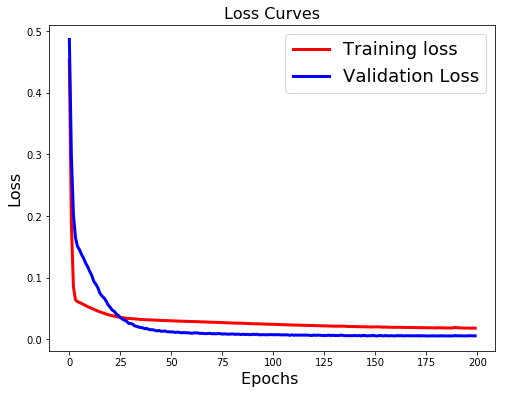

In [96]:
#Ploten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['loss'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [97]:
# Modellperformance bewerten: normalisierte Daten
trainScore = model.evaluate(trainX_100N, train_y_100N, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX_100N, test_y_100N, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.02 MSE (0.13 RMSE)
Test Score: 0.01 MSE (0.07 RMSE)


In [98]:
# Vorhersagen generieren
trainPredict_100N = model.predict(trainX_100N)
testPredict_100N = model.predict(testX_100N)

In [99]:
# Prediction Denormalizing
testPredict_100=scaler.inverse_transform(testPredict_100N)
trainPredict_100=scaler.inverse_transform(trainPredict_100N)

# Evaluation
test_MSE=mean_squared_error(test_y_100,testPredict_100)
train_MSE=mean_squared_error(train_y_100,trainPredict_100)

print(test_MSE,train_MSE)

32747979.60525469 105262828.88307834


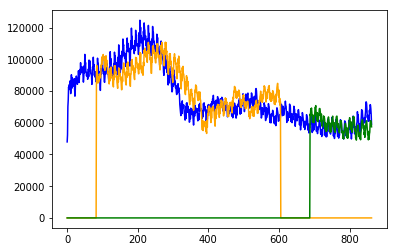

In [100]:
# Verschiebund der Trainingsvorhersage zum Plotten

trainPredictPlot = np.empty_like(ZR_100)
trainPredictPlot=trainPredictPlot.reshape(len(ZR_100))
trainPredictPlot[:]=[0]*len(ZR_100)
trainPredictPlot = trainPredictPlot.reshape(len(ZR_100),1)
trainPredictPlot[(look_back+look_forward-1):len(trainPredict_100)+(look_back+look_forward-1)] = trainPredict_100

# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_100)
testPredictPlot=testPredictPlot.reshape(len(ZR_100))
testPredictPlot[:]=[0]*len(ZR_100)
testPredictPlot = testPredictPlot.reshape(len(ZR_100),1)
testPredictPlot[len(trainPredict_100)+(2*look_back+2*look_forward-2):len(ZR_100)-(look_back+look_forward-1)+look_back+look_forward] = testPredict_100
 
# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_100, color='blue')
plt.plot(trainPredictPlot, color='orange') 
plt.plot(testPredictPlot, color='green')
plt.show()

In [157]:
# Replizierbarkeit gewährleisten
np.random.seed(7)

In [158]:
# Modell zusammenbauen
# Dateninput: 46 %
model = Sequential()
model.add(Dense(10, input_dim=look_back, activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history_reg=model.fit(trainX_46N, train_y_46N, epochs=200, batch_size=25, verbose=2,validation_data=(testX_46N, test_y_46N))

Train on 167 samples, validate on 67 samples
Epoch 1/200
 - 1s - loss: 0.0966 - val_loss: 0.0199
Epoch 2/200
 - 0s - loss: 0.0526 - val_loss: 0.0081
Epoch 3/200
 - 0s - loss: 0.0244 - val_loss: 0.0035
Epoch 4/200
 - 0s - loss: 0.0095 - val_loss: 0.0040
Epoch 5/200
 - 0s - loss: 0.0041 - val_loss: 0.0064
Epoch 6/200
 - 0s - loss: 0.0034 - val_loss: 0.0083
Epoch 7/200
 - 0s - loss: 0.0038 - val_loss: 0.0088
Epoch 8/200
 - 0s - loss: 0.0039 - val_loss: 0.0083
Epoch 9/200
 - 0s - loss: 0.0036 - val_loss: 0.0075
Epoch 10/200
 - 0s - loss: 0.0034 - val_loss: 0.0067
Epoch 11/200
 - 0s - loss: 0.0033 - val_loss: 0.0062
Epoch 12/200
 - 0s - loss: 0.0033 - val_loss: 0.0059
Epoch 13/200
 - 0s - loss: 0.0033 - val_loss: 0.0059
Epoch 14/200
 - 0s - loss: 0.0033 - val_loss: 0.0060
Epoch 15/200
 - 0s - loss: 0.0033 - val_loss: 0.0061
Epoch 16/200
 - 0s - loss: 0.0033 - val_loss: 0.0061
Epoch 17/200
 - 0s - loss: 0.0033 - val_loss: 0.0061
Epoch 18/200
 - 0s - loss: 0.0032 - val_loss: 0.0059
Epoch 19/2

Epoch 154/200
 - 0s - loss: 0.0021 - val_loss: 0.0044
Epoch 155/200
 - 0s - loss: 0.0021 - val_loss: 0.0044
Epoch 156/200
 - 0s - loss: 0.0021 - val_loss: 0.0043
Epoch 157/200
 - 0s - loss: 0.0021 - val_loss: 0.0045
Epoch 158/200
 - 0s - loss: 0.0021 - val_loss: 0.0044
Epoch 159/200
 - 0s - loss: 0.0021 - val_loss: 0.0042
Epoch 160/200
 - 0s - loss: 0.0021 - val_loss: 0.0045
Epoch 161/200
 - 0s - loss: 0.0021 - val_loss: 0.0046
Epoch 162/200
 - 0s - loss: 0.0021 - val_loss: 0.0045
Epoch 163/200
 - 0s - loss: 0.0021 - val_loss: 0.0046
Epoch 164/200
 - 0s - loss: 0.0021 - val_loss: 0.0046
Epoch 165/200
 - 0s - loss: 0.0021 - val_loss: 0.0045
Epoch 166/200
 - 0s - loss: 0.0021 - val_loss: 0.0045
Epoch 167/200
 - 0s - loss: 0.0021 - val_loss: 0.0046
Epoch 168/200
 - 0s - loss: 0.0021 - val_loss: 0.0047
Epoch 169/200
 - 0s - loss: 0.0021 - val_loss: 0.0048
Epoch 170/200
 - 0s - loss: 0.0021 - val_loss: 0.0046
Epoch 171/200
 - 0s - loss: 0.0021 - val_loss: 0.0046
Epoch 172/200
 - 0s - loss: 

Text(0.5,1,'Loss Curves')

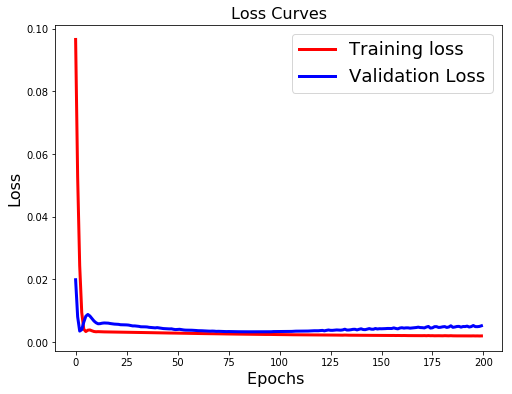

In [159]:
#Ploten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['loss'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [160]:
# Modellperformance bewerten
trainScore = model.evaluate(trainX_46N, train_y_46N, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX_46N, test_y_46N, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00 MSE (0.04 RMSE)
Test Score: 0.01 MSE (0.07 RMSE)


In [161]:
# Vorhersagen generieren
trainPredict_46N = model.predict(trainX_46N)
testPredict_46N = model.predict(testX_46N)

In [162]:
# Prediction Denormalizing
testPredict_46=scaler.inverse_transform(testPredict_46N)
trainPredict_46=scaler.inverse_transform(trainPredict_46N)

# Evaluation
test_MSE=mean_squared_error(test_y_46,testPredict_46)
train_MSE=mean_squared_error(train_y_46,trainPredict_46)

print(test_MSE,train_MSE)

30697752.052685183 11528702.58345379


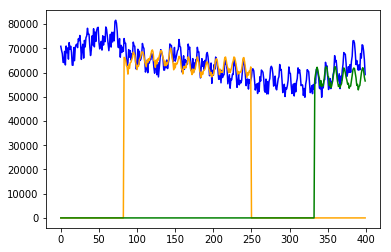

In [163]:
# Verschiebund der Trainingsvorhersage zum Plotten
trainPredictPlot = np.empty_like(ZR_46)
trainPredictPlot=trainPredictPlot.reshape(len(ZR_46))
trainPredictPlot[:]=[0]*len(ZR_46)
trainPredictPlot = trainPredictPlot.reshape(len(ZR_46),1)
trainPredictPlot[(look_back+look_forward-1):len(trainPredict_46)+(look_back+look_forward-1)] = trainPredict_46

# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_46)
testPredictPlot=testPredictPlot.reshape(len(ZR_46))
testPredictPlot[:]=[0]*len(ZR_46)
testPredictPlot = testPredictPlot.reshape(len(ZR_46),1)
testPredictPlot[len(trainPredict_46)+2*(look_back+look_forward-1):len(ZR_46)-(look_back+look_forward-1)+look_back+look_forward] = testPredict_46
 
# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_46, color='blue')
plt.plot(trainPredictPlot, color='orange') 
plt.plot(testPredictPlot, color='green')
plt.show()